# Pre-Examination #1 - New York City Taxi Trip Duration

### Dataset Description:
#### Dataset Kaggle Link:
Dataset: [Kaggle NYC Taxi Trip Duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview)

#### Features:
1. `id` - a unique identifier for each trip;
2. `vendor_id` - a code indicating the provider associated with the trip record;
3. `pickup_datetime` - date and time when the meter was engaged;
4. `dropoff_datetime` - date and time when the meter was disengaged (not available in test subset);
5. `passenger_count` - the number of passengers in the vehicle (driver entered value);
6. `pickup_longitude` - the longitude where the meter was engaged;
7. `pickup_latitude` - the latitude where the meter was engaged;
8. `dropoff_longitude` - the longitude where the meter was disengaged;
9. `dropoff_latitude` - the latitude where the meter was disengaged;
10. `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - `Y` = store and forward; `N` = not a store and forward trip;
11. `trip_duration` - duration of the trip in seconds.

#### Target:
Since there is a column with continuous numerical values that will offer true label values for each record in the dataset - `trip_duration`, this dataset is designed for a Supervised Machine Learning Problem. This column holds information about the duration of each trip.

#### `dropoff_datetime`:
Since `dropoff_datetime` and `pickup_datetime` together may give the trip duration by themselves, without the need of training a model, test subset does not include this column, which disables the possibility to use this column as a feature. However, since training subset contains this column, it may be used only for analysis part of the work.

### Problem Description:
This dataset was collected by an taxi agency in New York City - [New York City Taxi and Limousine Commission (NYC TLC)](https://www.nyc.gov/site/tlc/index.page) offers information about total ride duration of taxi trips in New York City. Besides that, on Kaggle page was mentioned that this dataset was sampled and cleaned, with no additional information about what procedures were done on this dataset, which is a subject of further analysis to determine the applied methods. The task is to train a **Regression Model**, that will predict the **duration of the trip** based on several factors, such as: **passenger count**, **date** and **time** when **meter was engaged** and **disengaged**, and so on.


In [1]:
# Import Data Structures
import pandas as pd
import dask.dataframe as dd

# Import Data Manipulation Libraries
import numpy as np
import math

# Import Distance Calculation Methods
from geopy.distance import geodesic
import osmnx as ox

# Import Base Classes for Type Annotation
from sklearn.base import BaseEstimator

# Import Structure Manipulation Methods
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import Visualization Libs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style(style="whitegrid")
sns.set_palette('bright')
# from dtreeviz import model

# Import Outlier Detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Import Feature Selection Methods
from kydavra import PValueSelector
from sklearn.feature_selection import RFECV

# Import Hyperparameter Tuning
import optuna

# Import ML Models
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Import Interpretation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, root_mean_squared_log_error, make_scorer
# from lime.lime_tabular import LimeTabularExplainer
# import shap

# Import Custom Utils
from utils import get_percentage_cat_col, get_distance_osmnx, get_distance_api, get_distance_haversine, measure_time_function, get_outliers_by_boxplot
import swifter

## Dataset Loading

In [2]:
taxi_duration_df: pd.DataFrame = pd.read_csv(filepath_or_buffer='dataset/train.csv', 
                                             sep=',')

In [3]:
taxi_duration_df_copy = taxi_duration_df.copy(deep=True)

In [4]:
taxi_duration_df.head(n=10)

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435
5  id0801584          2  ...                  N           443
6  id1813257          1  ...                  N           341
7  id1324603          2  ...                  N          1551
8  id1301050          1  ...                  N           255
9  id0012891          2  ...                  N          1225

[10 rows x 11 columns]

In [5]:
taxi_duration_df.tail(n=10)

id  vendor_id  ... store_and_fwd_flag trip_duration
1458634  id3445276          1  ...                  N           972
1458635  id3027038          2  ...                  N           237
1458636  id0405770          2  ...                  N           800
1458637  id1920898          1  ...                  N           760
1458638  id1454193          2  ...                  N           414
1458639  id2376096          2  ...                  N           778
1458640  id1049543          1  ...                  N           655
1458641  id2304944          2  ...                  N           764
1458642  id2714485          1  ...                  N           373
1458643  id1209952          1  ...                  N           198

[10 rows x 11 columns]

In [6]:
print(f'Dataset shape: {taxi_duration_df.shape[0]} rows and {taxi_duration_df.shape[1]} columns')

Dataset shape: 1458644 rows and 11 columns


As it may be seen, this dataset contains information about $\approx$ 1.46 million rows and contains 11 columns - 10 features and 1 target, as it was specified above.

In [7]:
taxi_duration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


There are several features that are of `object` type, which are of `String` data type, such as: `id`, `pickup_datetime`, `dropoff_datetime`, `store_and_fwd_flag`. However, as it was seen above, by direct observations, `pickup_datetime` and `dropoff_datetime` are of `DateTime` data type, to which they will be converted further. Besides them, there is another column that contained only two unique values when the dataset head and tail were analyzed, therefore, there may be needed an evaluation of unique values of other columns as well. Rest of the columns should be analyzed closely to verify their actual data type for numerical conversion.

In [8]:
for column in taxi_duration_df.columns:
    unique_values_col: np.ndarray = taxi_duration_df[column].unique()
    print(f'Column {column}: {unique_values_col} - {len(unique_values_col)}')
    del unique_values_col

Column id: ['id2875421' 'id2377394' 'id3858529' ... 'id2304944' 'id2714485'
 'id1209952'] - 1458644
Column vendor_id: [2 1] - 2
Column pickup_datetime: ['2016-03-14 17:24:55' '2016-06-12 00:43:35' '2016-01-19 11:35:24' ...
 '2016-01-10 07:35:15' '2016-04-22 06:57:41' '2016-01-05 15:56:26'] - 1380222
Column dropoff_datetime: ['2016-03-14 17:32:30' '2016-06-12 00:54:38' '2016-01-19 12:10:48' ...
 '2016-04-22 07:10:25' '2016-01-05 16:02:39' '2016-04-05 14:47:43'] - 1380377
Column passenger_count: [1 6 4 2 3 5 0 7 9 8] - 10
Column pickup_longitude: [-73.98215485 -73.98041534 -73.97902679 ... -73.84746552 -73.89477539
 -73.84131622] - 23047
Column pickup_latitude: [40.76793671 40.73856354 40.7639389  ... 40.69665146 40.83586502
 40.82304382] - 45245
Column dropoff_longitude: [-73.96463013 -73.9994812  -74.00533295 ... -73.85946655 -74.04266357
 -73.76462555] - 33821
Column dropoff_latitude: [40.76560211 40.73115158 40.71008682 ... 40.65151978 40.64244461
 40.62860489] - 62519
Column store_a

As it may be noticed, the column of `store_and_fwd_flag` contains only two unique values, which means that this column may be converted into a binary feature using numerical values - `0` for `N` and `1` - for `Y`. `id` column contains unique values for each record in the dataset, and can be dropped since this column contains no valuable information and is used to give a unique Identifier for each row in the dataset. `pickup_datetime` and `dropoff_datetime` are `datetime` variables and will be converted accordingly. Similarly, `vendor_id` contains information about specific trip record vendor, which contained only 2 values.

In [9]:
columns_to_drop_eda: list[str] = ['id', 'dropoff_datetime']
columns_to_drop_model: list[str] = ['id', 'dropoff_datetime', 'pickup_datetime']
datetime_columns: list[str] = ['pickup_datetime', 'dropoff_datetime']
binary_columns: list[str] = ['store_and_fwd_flag', 'vendor_id']
location_columns: list[str] = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

At the same time, there were trips with no passengers. As it was mentioned in [Features Description](#features), the `passenger_count` is the value entered by driver, which could indicate that driver did not enter the number of passengers during taxi trip, but further analysis is required.

In [10]:
taxi_duration_df.describe()

vendor_id  passenger_count  ...  dropoff_latitude  trip_duration
count  1.458644e+06     1.458644e+06  ...      1.458644e+06   1.458644e+06
mean   1.534950e+00     1.664530e+00  ...      4.075180e+01   9.594923e+02
std    4.987772e-01     1.314242e+00  ...      3.589056e-02   5.237432e+03
min    1.000000e+00     0.000000e+00  ...      3.218114e+01   1.000000e+00
25%    1.000000e+00     1.000000e+00  ...      4.073588e+01   3.970000e+02
50%    2.000000e+00     1.000000e+00  ...      4.075452e+01   6.620000e+02
75%    2.000000e+00     2.000000e+00  ...      4.076981e+01   1.075000e+03
max    2.000000e+00     9.000000e+00  ...      4.392103e+01   3.526282e+06

[8 rows x 7 columns]

Dataset is not standardized and contains values in their original form. At the same time, it may be noticed that `trip_duration` column minimal value is 1 second, which may show an anomaly in records and should be treated accordingly. At the same time, `passenger_count` minimum is $0$ which also may lead to an anomaly.

## Feature Engineering
Since there are several columns that contain important information, such as: period of the day when trip was recorded, road distance and so on, several new features may be formed using them.

### Data Conversion
First, `String` to `DateTime` was done using built-in `pandas` function - `to_datetime`.

In [11]:
taxi_duration_df[datetime_columns] = taxi_duration_df[datetime_columns].swifter.progress_bar(enable=True, desc='Convert to DateTime').apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

Convert to DateTime:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
taxi_duration_df.head(n=5)

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

### New Features

#### Distance Feature
An API ([DistanceMatrix.AI](https://account.distancematrix.ai/)) was used to determine the Road Distance between Pickup Latitude and Longitude and Dropoff Latidude and Longitude. However, due to API usage limitation, a library - [OSMNX](https://osmnx.readthedocs.io/en/stable/index.html) was tried, that is using OpenStreetMap and find the path between points using Graphs and Path Finding Algorithms. In this case, the problem of the dataset appears - since it is quite big, computation takes a lot of time. Was decided to use straight-forward, not always close to truth, but still useful way of computing distance between points - Harversine Formula, which takes into consideration the curvature of the Earth:
$$
\begin{align*}
a &= \sin^2\left(\frac{\Delta\phi}{2}\right) + \cos \phi_1 \cdot \cos \phi_2 \cdot \sin^2\left(\frac{\Delta\lambda}{2}\right) \\
c &= 2 \cdot \arctan2(\sqrt{a}, \sqrt{1-a}) \\
d &= R \cdot c
\end{align*}
$$
Also, there is a possibility to use Manhattan Formula, that is also called taxicab formula, which is a good choice to use in determination of distance between two points in a grid-like city structure. Besides that, `geopy` offers another method of calculation of distance, based on the actual form of the Earth - geoid.

In [13]:
taxi_duration_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]

pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude
0              40.767937        -73.982155         40.765602         -73.964630
1              40.738564        -73.980415         40.731152         -73.999481
2              40.763939        -73.979027         40.710087         -74.005333
3              40.719971        -74.010040         40.706718         -74.012268
4              40.793209        -73.973053         40.782520         -73.972923
...                  ...               ...               ...                ...
1458639        40.745522        -73.982201         40.740170         -73.994911
1458640        40.747379        -74.000946         40.796547         -73.970184
1458641        40.768799        -73.959129         40.707371         -74.004433
1458642        40.749062        -73.982079         40.757107         -73.974632
1458643        40.781750        -73.979538         40.790585         -73.972809

[1458644 rows x 4 columns]

In [14]:
# north = taxi_duration_df[['pickup_latitude', 'dropoff_latitude']].max().max()
# south = taxi_duration_df[['pickup_latitude', 'dropoff_latitude']].min().min()
# east  = taxi_duration_df[['pickup_longitude', 'dropoff_longitude']].max().max()
# west  = taxi_duration_df[['pickup_longitude', 'dropoff_longitude']].min().min()

# bbox = (west - 0.01, south - 0.01, east + 0.01, north + 0.01)

G = ox.graph_from_place("New York City, New York, USA", network_type="drive")
print(f'Graph created with {len(G.nodes)} nodes and {len(G.edges)} edges')
# G = ox.truncate.truncate_graph_bbox(G, bbox)
# print(f'Graph truncated to bbox with {len(G.nodes)} nodes and {len(G.edges)} edges')

Graph created with 55266 nodes and 139294 edges


In [15]:
def get_distance_manhattan(row: pd.Series) -> float:
    lat_dist = abs(row['dropoff_latitude'] - row['pickup_latitude']) * 111320  # Convert degrees to kilometers
    lon_dist = abs(row['dropoff_longitude'] - row['pickup_longitude']) * 111320 * math.cos(row['pickup_latitude'] * math.pi / 180)
    return lat_dist + lon_dist

In [16]:
# taxi_duration_df['road_distance'] = taxi_duration_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Duration Calculation').apply(
#     lambda rec: get_distance_osmnx(
#         row=rec,
#         G=G
#     ), axis=1
# )

taxi_duration_df['road_distance'] = taxi_duration_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Duration Calculation').apply(
    lambda rec: get_distance_manhattan(row=rec), 
    axis=1
)

Duration Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [17]:
taxi_duration_df

id  vendor_id  ... trip_duration road_distance
0        id2875421          2  ...           455   1737.385329
1        id2377394          1  ...           663   2433.239937
2        id3858529          2  ...          2124   8212.802551
3        id3504673          2  ...           429   1663.199924
4        id2181028          2  ...           435   1200.805926
...            ...        ...  ...           ...           ...
1458639  id2376096          2  ...           778   1667.768688
1458640  id1049543          1  ...           655   8067.644541
1458641  id2304944          2  ...           764  10657.620193
1458642  id2714485          1  ...           373   1523.561588
1458643  id1209952          1  ...           198   1550.704771

[1458644 rows x 12 columns]

In [18]:
taxi_duration_df[taxi_duration_df['road_distance'] == 0]

id  vendor_id  ... trip_duration road_distance
246      id3487442          2  ...           227           0.0
291      id0924324          2  ...          1109           0.0
407      id1145809          2  ...           947           0.0
702      id3499387          1  ...           580           0.0
1620     id0753277          1  ...            27           0.0
...            ...        ...  ...           ...           ...
1456399  id0618137          2  ...          1284           0.0
1456627  id1048767          2  ...           127           0.0
1456989  id2595295          2  ...           566           0.0
1457114  id0051314          2  ...           632           0.0
1457136  id1907784          1  ...           176           0.0

[5897 rows x 12 columns]

In [19]:
print(f"Anomaly Taxi Trips: {taxi_duration_df[taxi_duration_df['road_distance'] == 0].shape[0]}")
print(f"Total Taxi Trips: {taxi_duration_df.shape[0]}")
print(f"Percentage of Anomaly Taxi Trips: {(taxi_duration_df[taxi_duration_df['road_distance'] == 0].shape[0] / taxi_duration_df.shape[0] * 100):.5f}%")

Anomaly Taxi Trips: 5897
Total Taxi Trips: 1458644
Percentage of Anomaly Taxi Trips: 0.40428%


As it may be seen, there are several cases when `road_distance` is equal to zero. By further analysis, was concluded that both pickup and dropoff coordinates are the same, which resulted in values equal to 0. 

In order to compare the above mentioned methods, below is provided the calculated road lengths using all 5 methods.

In [20]:
def get_distance_vincenty(row: pd.Series) -> float:
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(coords_1, coords_2).meters

In [21]:
for i in range(5):
    rec = taxi_duration_df.iloc[i]
    print(f"\nData Sample Point - {i}")

    print("Road Distance using API Call:")
    result, elapsed_time = measure_time_function(get_distance_api, row=rec)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")

    print("Road Distance using OSMNX Library:")
    result, elapsed_time = measure_time_function(get_distance_osmnx, row=rec, G=G)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")

    print("Road Distance using Haversine Formula:")
    result, elapsed_time = measure_time_function(get_distance_haversine, row=rec)
    print(f"Distance: {result * 1000} meters, Time: {elapsed_time:.2f} seconds")

    print("Road Distance using Manhattan Formula:")
    result, elapsed_time = measure_time_function(get_distance_manhattan, row=rec)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")

    print("Road Distance using Geopy.Geodesic:")
    result, elapsed_time = measure_time_function(get_distance_vincenty, row=rec)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")


Data Sample Point - 0
Road Distance using API Call:
Distance: 1916 meters, Time: 0.28 seconds
Road Distance using OSMNX Library:
Distance: 1967.5906469194654 meters, Time: 0.28 seconds
Road Distance using Haversine Formula:
Distance: 1498522.849490913 meters, Time: 0.42 seconds
Road Distance using Manhattan Formula:
Distance: 1737.385329291822 meters, Time: 0.00 seconds
Road Distance using Geopy.Geodesic:
Distance: 1502.1718368830568 meters, Time: 0.00 seconds

Data Sample Point - 1
Road Distance using API Call:
Distance: 2516 meters, Time: 0.24 seconds
Road Distance using OSMNX Library:
Distance: 2500.1114033177855 meters, Time: 0.29 seconds
Road Distance using Haversine Formula:
Distance: 1805509.662669238 meters, Time: 0.00 seconds
Road Distance using Manhattan Formula:
Distance: 2433.2399366205264 meters, Time: 0.00 seconds
Road Distance using Geopy.Geodesic:
Distance: 1808.6599689816733 meters, Time: 0.00 seconds

Data Sample Point - 2
Road Distance using API Call:
Distance: 9899

#### Time-based Features
Since there is one significant feature that is of data type `DateTime`, several options may be selected in order to represent those values in a more useful format. For example, `pickup_datetime`, which is the feature that should be taken in consideration for Model Training, may hold information about the specific day of the week, when the taxi trip was done, as well the period of the day, which also influences the duration of the trip, since in different periods of the day different road traffic may be encountered.

In [22]:
pickup_rounded = taxi_duration_df['pickup_datetime'].dt.round('H')
dropoff_rounded = taxi_duration_df['dropoff_datetime'].dt.round('H')


taxi_duration_df['pickup_month'] = pickup_rounded.dt.month
taxi_duration_df['pickup_day'] = pickup_rounded.dt.weekday
taxi_duration_df['pickup_hour'] = pickup_rounded.dt.hour
taxi_duration_df['pickup_period_of_day'] = taxi_duration_df['pickup_hour'].swifter.progress_bar(enable=True, desc=f'Period of Day').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
taxi_duration_df['pickup_is_weekend'] = taxi_duration_df['pickup_day'].swifter.progress_bar(enable=True, desc=f'Is Weekend').apply(
            lambda x: 1 if x in [5, 6] else 0
        )
taxi_duration_df['pickup_season'] = taxi_duration_df['pickup_month'].swifter.progress_bar(enable=True, desc=f'Season').apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
                'Spring' if x in [3, 4, 5] else
                'Summer' if x in [6, 7, 8] else
                'Autumn'
)

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Season:   0%|          | 0/1458644 [00:00<?, ?it/s]

In [23]:
taxi_duration_df['dropoff_month'] = dropoff_rounded.dt.month
taxi_duration_df['dropoff_day'] = dropoff_rounded.dt.weekday
taxi_duration_df['dropoff_hour'] = dropoff_rounded.dt.hour
taxi_duration_df['dropoff_period_of_day'] = taxi_duration_df['dropoff_hour'].swifter.progress_bar(enable=True, desc=f'Period of Day').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
taxi_duration_df['dropoff_is_weekend'] = taxi_duration_df['dropoff_day'].swifter.progress_bar(enable=True, desc=f'Is Weekend').apply(
            lambda x: 1 if x in [5, 6] else 0
        )
taxi_duration_df['dropoff_season'] = taxi_duration_df['dropoff_month'].swifter.progress_bar(enable=True, desc=f'Season').apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
                'Spring' if x in [3, 4, 5] else
                'Summer' if x in [6, 7, 8] else
                'Autumn'
)

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Season:   0%|          | 0/1458644 [00:00<?, ?it/s]

Since `dropoff_datetime` column is not avaiable in `test.zip` dataset on Kaggle, this column should not be used as a feature, and may be used only for analysis, therefore newly created features should be dropped afterwards.

In [24]:
# columns_to_drop_model.extend(['dropoff_month', 'dropoff_day', 'dropoff_hour', 'dropoff_period_of_day', 'dropoff_is_weekend', 'dropoff_season', 'pickup_datetime'])
# columns_to_drop_model

In [25]:
taxi_duration_df

id  vendor_id  ... dropoff_is_weekend dropoff_season
0        id2875421          2  ...                  0         Spring
1        id2377394          1  ...                  1         Summer
2        id3858529          2  ...                  0         Winter
3        id3504673          2  ...                  0         Spring
4        id2181028          2  ...                  1         Spring
...            ...        ...  ...                ...            ...
1458639  id2376096          2  ...                  0         Spring
1458640  id1049543          1  ...                  1         Winter
1458641  id2304944          2  ...                  0         Spring
1458642  id2714485          1  ...                  0         Winter
1458643  id1209952          1  ...                  0         Spring

[1458644 rows x 24 columns]

### Feature Engineering Pipeline

In [26]:
def extract_datetime_features_bp(df: pd.DataFrame, dt_cols: list[str]) -> pd.DataFrame:
    for col in dt_cols:
        df[col] = df[col].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
        col_rounded = df[col].dt.round('H')
        df[f'{col.split(sep="_")[0]}_month'] = col_rounded.dt.month
        df[f'{col.split(sep="_")[0]}_day'] = col_rounded.dt.weekday
        df[f'{col.split(sep="_")[0]}_hour'] = col_rounded.dt.hour

    return df

In [27]:
def extract_datetime_features_tf(df: pd.DataFrame, dt_cols: list[str]) -> pd.DataFrame:
    for col in dt_cols:
        df[col] = df[col].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
        col_rounded = df[col].dt.round('H')
        df[f'{col.split(sep="_")[0]}_month'] = col_rounded.dt.month
        df[f'{col.split(sep="_")[0]}_day'] = col_rounded.dt.weekday
        df[f'{col.split(sep="_")[0]}_hour'] = col_rounded.dt.hour

        df[f'{col.split(sep="_")[0]}_period_of_day'] = df[f'{col.split(sep="_")[0]}_hour'].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
        
        df[f'{col.split(sep="_")[0]}_is_weekend'] = df[f'{col.split(sep="_")[0]}_day'].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(
            lambda x: 1 if x in [5, 6] else 0
        )
    
    return df

In [28]:
def extract_datetime_features_fe(df: pd.DataFrame, dt_cols: list[str]) -> pd.DataFrame:
    for col in dt_cols:
        df[col] = df[col].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
        col_rounded = df[col].dt.round('H')
        df[f'{col.split(sep="_")[0]}_month'] = col_rounded.dt.month
        df[f'{col.split(sep="_")[0]}_day'] = col_rounded.dt.weekday
        df[f'{col.split(sep="_")[0]}_hour'] = col_rounded.dt.hour

        df[f'{col.split(sep="_")[0]}_period_of_day'] = df[f'{col.split(sep="_")[0]}_hour'].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
        df[f'{col.split(sep="_")[0]}_is_weekend'] = df[f'{col.split(sep="_")[0]}_day'].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(
            lambda x: 1 if x in [5, 6] else 0
        )
        df[f'{col.split(sep="_")[0]}_season'] = df[f'{col.split(sep="_")[0]}_month'].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(
            lambda x: 'Winter' if x in [12, 1, 2] else
                      'Spring' if x in [3, 4, 5] else
                      'Summer' if x in [6, 7, 8] else
                      'Autumn'
        )

    return df

In [29]:
def extract_distance_features(df: pd.DataFrame) -> pd.DataFrame:
    df['road_distance'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_manhattan(row=rec), axis=1
    )
    return df

In [30]:
datetime_transformer_eda = FunctionTransformer(extract_datetime_features_fe, kw_args={'dt_cols': datetime_columns}, validate=False)
distance_transformer = FunctionTransformer(extract_distance_features, validate=False)

In [31]:
feature_engineering_transformer_eda = ColumnTransformer(
    transformers=[
        ('datetime', datetime_transformer_eda, datetime_columns),
        ('distance', distance_transformer, location_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [32]:
drop_transformer_eda = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop_eda)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [33]:
feature_engineering_pipeline = Pipeline(
    steps=[
        ('feature_engineering', feature_engineering_transformer_eda),
        ('drop_columns', drop_transformer_eda)
    ]
).set_output(transform='pandas')

In [34]:
taxi_duration_df_copy_transformed_eda = feature_engineering_pipeline.fit_transform(taxi_duration_df_copy)

Convert pickup_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert pickup_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert pickup_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert dropoff_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert dropoff_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert dropoff_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [35]:
taxi_duration_df_copy_transformed_eda

pickup_datetime  pickup_month  ...  store_and_fwd_flag  trip_duration
0       2016-03-14 17:24:55             3  ...                   N            455
1       2016-06-12 00:43:35             6  ...                   N            663
2       2016-01-19 11:35:24             1  ...                   N           2124
3       2016-04-06 19:32:31             4  ...                   N            429
4       2016-03-26 13:30:55             3  ...                   N            435
...                     ...           ...  ...                 ...            ...
1458639 2016-04-08 13:31:04             4  ...                   N            778
1458640 2016-01-10 07:35:15             1  ...                   N            655
1458641 2016-04-22 06:57:41             4  ...                   N            764
1458642 2016-01-05 15:56:26             1  ...                   N            373
1458643 2016-04-05 14:44:25             4  ...                   N            198

[1458644 rows x 22 columns]

In [36]:
list(set(taxi_duration_df.columns) - set(taxi_duration_df_copy_transformed_eda.columns))

['dropoff_datetime', 'id']

## Exploratory Data Analysis
To understand better the dataset, an EDA should be done. This refers to data visualization of the dataset components in order to find some patterns, anomalies or useful observations.

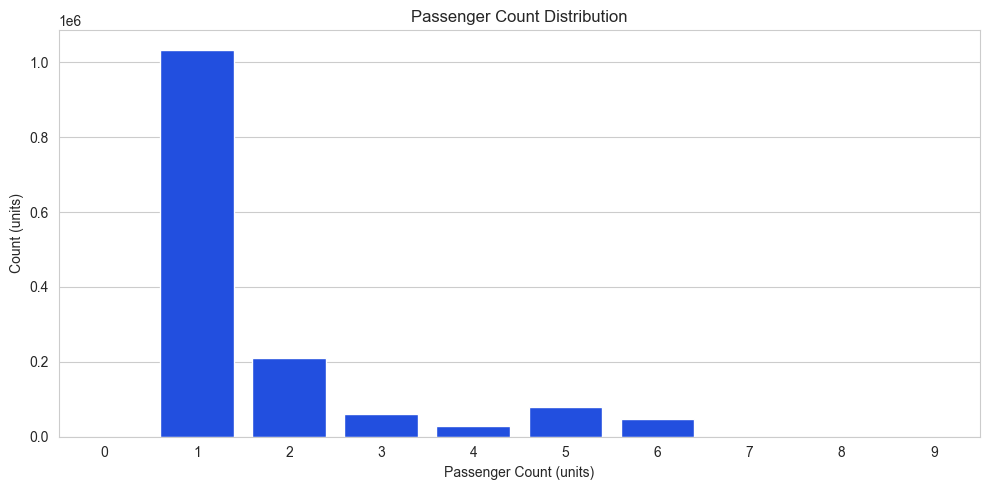

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.countplot(data=taxi_duration_df_copy_transformed_eda, x='passenger_count', ax=ax)

ax.set_title('Passenger Count Distribution')
ax.set_xlabel('Passenger Count (units)')
ax.set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

In [38]:
get_percentage_cat_col(taxi_duration_df_copy_transformed_eda, 'passenger_count')

passenger_count
1    70.856220
2    14.418734
5     5.353465
3     4.106280
6     3.313557
4     1.947288
0     0.004113
7     0.000206
9     0.000069
8     0.000069
Name: proportion, dtype: float64

Most taxi trips were with one or two passengers. Also, a higher number of trips were with larger companies of people - 5 and 6 persons. Very small number of trips with higher number of passengers and several trips with no passengers at all, which may be an error from driver - by not specifying the number of passengers or registering fake trips.

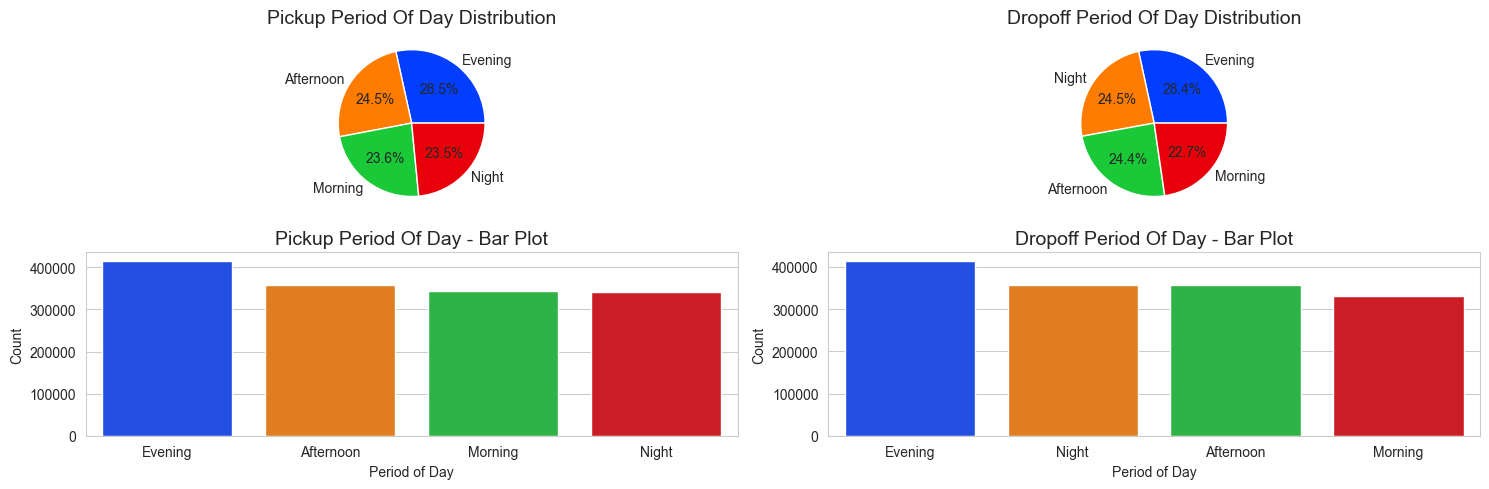

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(['pickup_period_of_day', 'dropoff_period_of_day']):
    counts = taxi_duration_df_copy_transformed_eda[col].value_counts()
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=sns.color_palette('bright', n_colors=len(counts))
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution', fontsize=14)

    sns.barplot(
        x=counts.index,
        y=counts.values,
        ax=axes[i + 2],
        palette='bright'
    )
    axes[i + 2].set_title(f'{col.replace("_", " ").title()} - Bar Plot', fontsize=14)
    axes[i + 2].set_xlabel('Period of Day')
    axes[i + 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

As it may be seen, most of the taxi trips were done during Evening Time, which is mainly the period of time when people are either finishing their day at work or outside till late night when no public transport is available. Interestingly, based on dropoff period, Night Time Taxi Trips are more common than Afternoon and Morning ones, while at pickup period - it is the least common. Most probably, this is due to the fact that most taxi trips are in the period when Evening switches with Night, that will be investigated below.

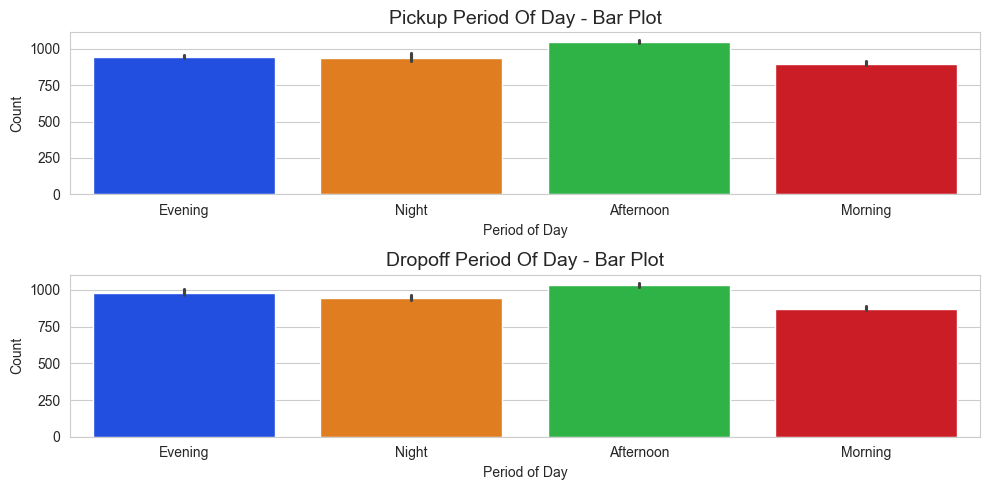

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
axes = axes.flatten()

for i, col in enumerate(['pickup_period_of_day', 'dropoff_period_of_day']):
    sns.barplot(
        data=taxi_duration_df_copy_transformed_eda,
        x=col,
        y='trip_duration',
        ax=axes[i],
        palette='bright'
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} - Bar Plot', fontsize=14)
    axes[i].set_xlabel('Period of Day')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

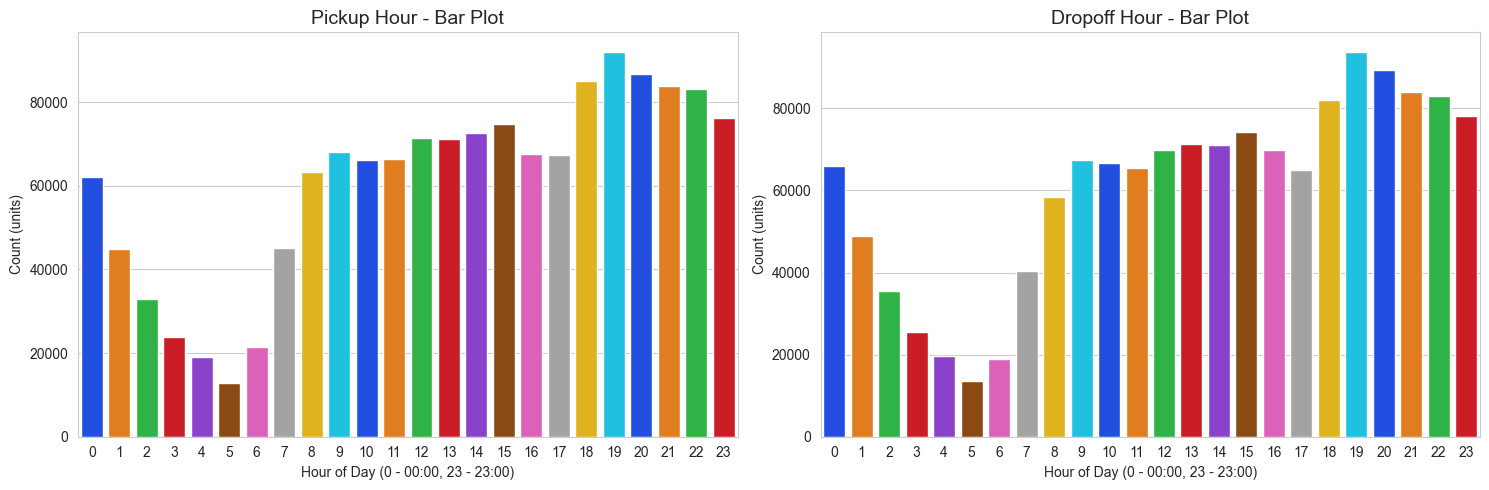

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_hour', 'dropoff_hour']):
    counts = taxi_duration_df_copy_transformed_eda[col].value_counts()
    sns.barplot(
        x=counts.index,
        y=counts.values,
        ax=axes[i],
        palette='bright'
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} - Bar Plot', fontsize=14)
    axes[i].set_xlabel('Hour of Day (0 - 00:00, 23 - 23:00)')
    axes[i].set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

As it may be seen, most of the trips are done in the Evening, close to Night period of the day, which is logically supporting the above conclusion and observations, that the change in the night trips between dropoff and pickup is supported by the fact that most of the taxi trips are done during the end of the Evening time and start of the Night time.

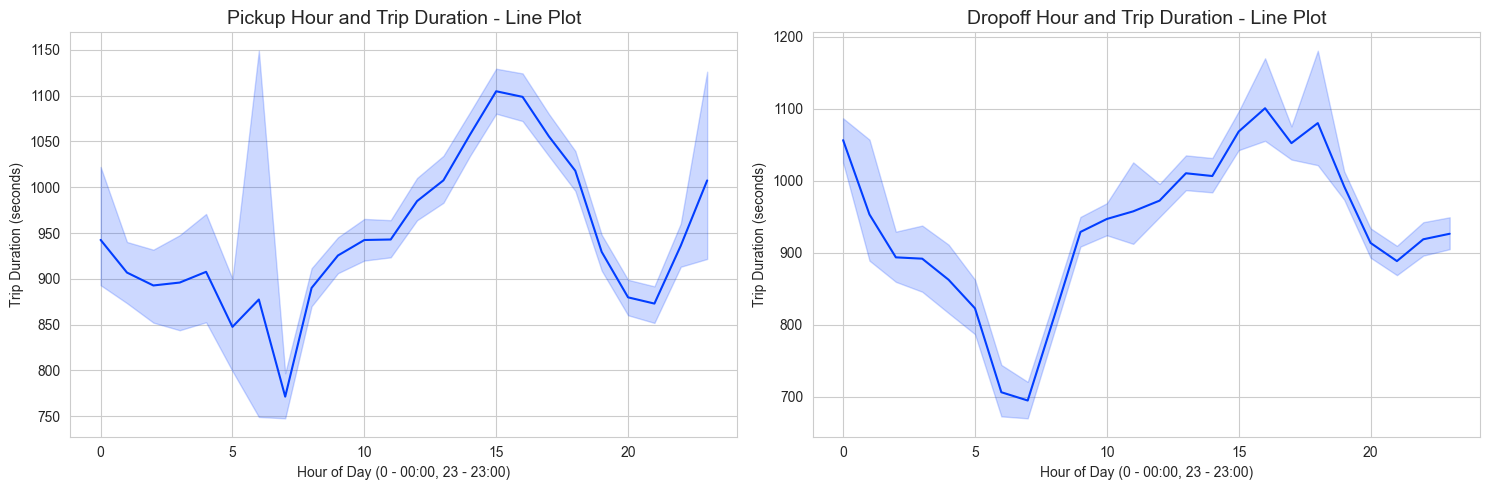

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_hour', 'dropoff_hour']):
    sns.lineplot(
        x=taxi_duration_df_copy_transformed_eda[col],
        y=taxi_duration_df_copy_transformed_eda['trip_duration'],
        ax=axes[i]
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} and Trip Duration - Line Plot', fontsize=14)
    axes[i].set_xlabel('Hour of Day (0 - 00:00, 23 - 23:00)')
    axes[i].set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

As it may be noticed, based on specific hour of the day when the taxi trip was done, a relationship between it and trip duration is visible. Highest duration is noticed at $\approx$ 14-19, which is in Afternoon, close to Evening period of the day, which is, again, correlated to the flux of road traffic and end of the work day. At the same time, a slight increase during first night hours is visible - $\approx$ 0 - 3, specifically in dropoff period, which is caused by night style of life of people that solicits cabs, since no public transport is available at that hour.

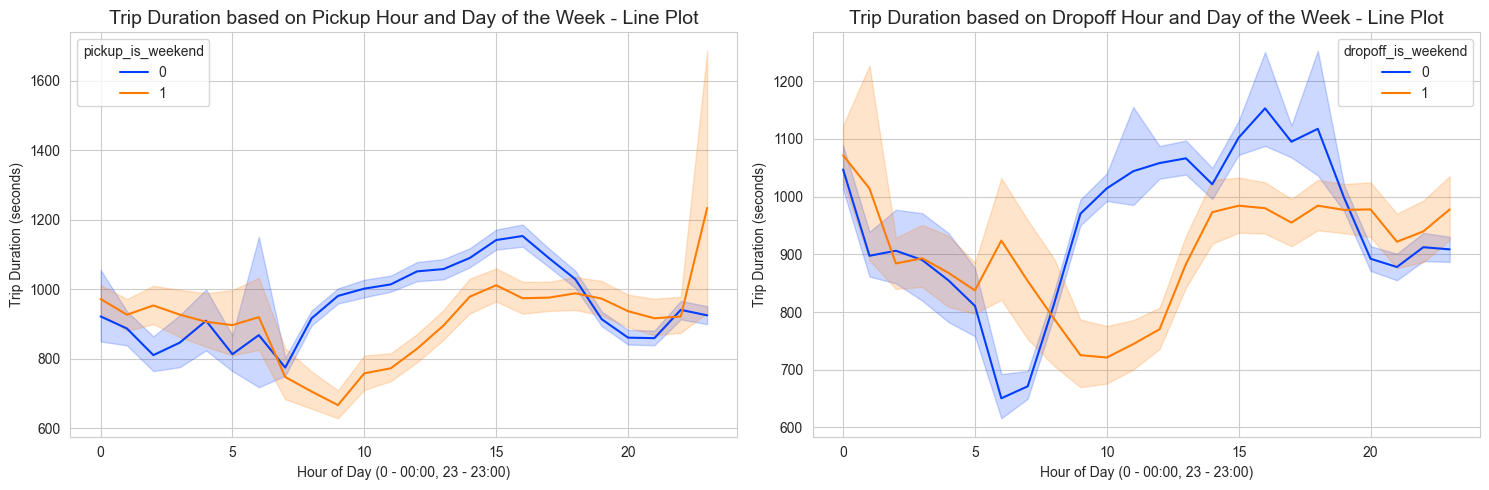

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_hour', 'dropoff_hour']):
    sns.lineplot(
        x=taxi_duration_df_copy_transformed_eda[col],
        y=taxi_duration_df_copy_transformed_eda['trip_duration'],
        ax=axes[i],
        hue=taxi_duration_df_copy_transformed_eda[f'{col.split(sep='_')[0]}_is_weekend'],
        palette='bright'
    )
    axes[i].set_title(f'Trip Duration based on {col.replace("_", " ").title()} and Day of the Week - Line Plot', fontsize=14)
    axes[i].set_xlabel('Hour of Day (0 - 00:00, 23 - 23:00)')
    axes[i].set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

Judging by the `is_weekend` columns, may be seen that, most of the day, specifically, Afternoon and Evening, the trip duration of taxi trips is lower than in working day, justified by the fact that most people are not working during weekends and traffic is easier. At the same time, slightly higher trip duration is noticed in the morning and night, probably caused by increased activity during nights on weekends - entertainment and so on, as well as higher traffic of people that are going out of town for these days.

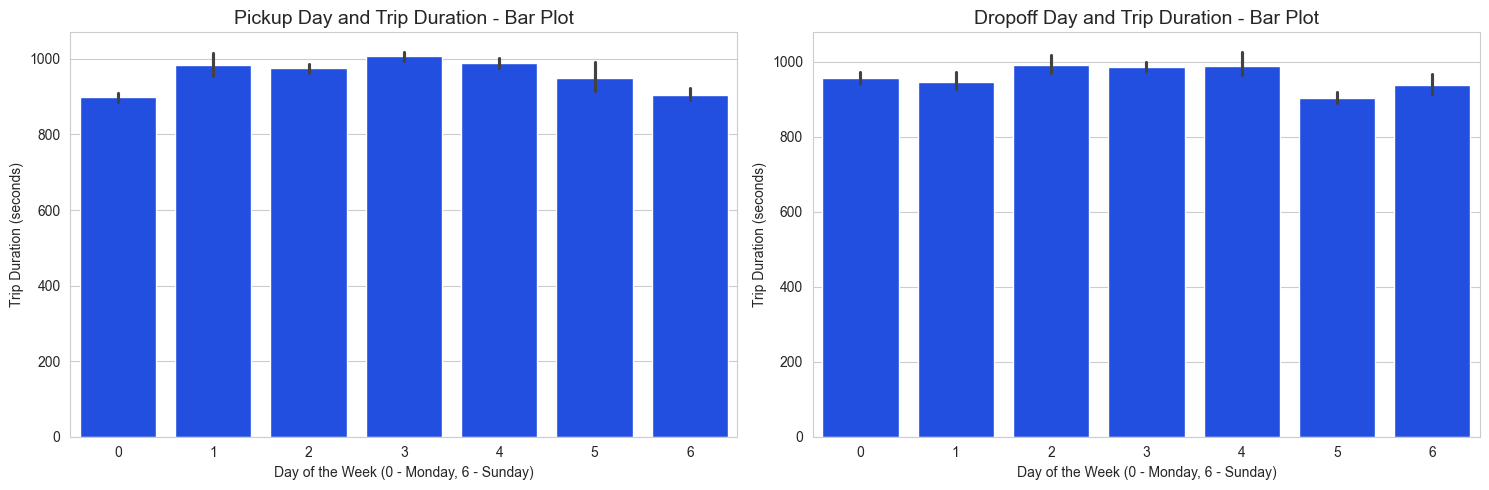

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_day', 'dropoff_day']):
    sns.barplot(
        x=taxi_duration_df_copy_transformed_eda[col],
        y=taxi_duration_df_copy_transformed_eda['trip_duration'],
        ax=axes[i]
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} and Trip Duration - Bar Plot', fontsize=14)
    axes[i].set_xlabel('Day of the Week (0 - Monday, 6 - Sunday)')
    axes[i].set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

No significant difference based on specific days of the week and trip duration. Slightly higher trip duration during working days of the week compared to the weekends, unsignificant however. 

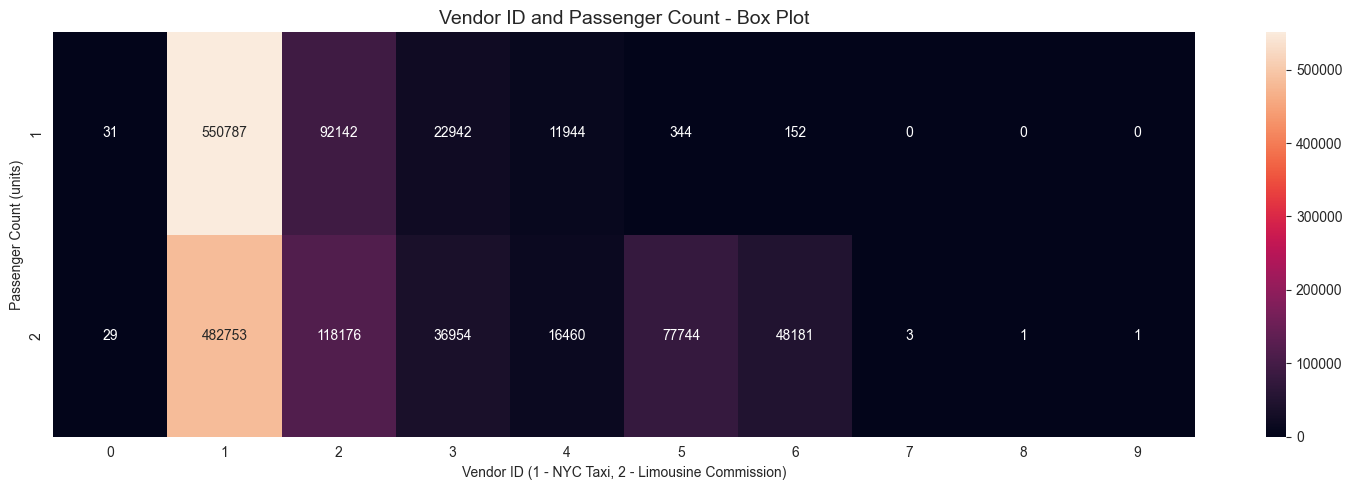

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.heatmap(
    pd.crosstab(taxi_duration_df_copy_transformed_eda['vendor_id'], taxi_duration_df_copy_transformed_eda['passenger_count']),
    annot=True,
    fmt='d',
    ax=ax
)
ax.set_title(f'Vendor ID and Passenger Count - Box Plot', fontsize=14)
ax.set_xlabel('Vendor ID (1 - NYC Taxi, 2 - Limousine Commission)')
ax.set_ylabel('Passenger Count (units)')

plt.tight_layout()
plt.show()

As it may be seen, Limousine Commission offers solutions and trips for higher number of passengers ($\ge 2 \text{ passengers}$), since it has cars with higher number of seats and for purposes, such as official meetings and other events.

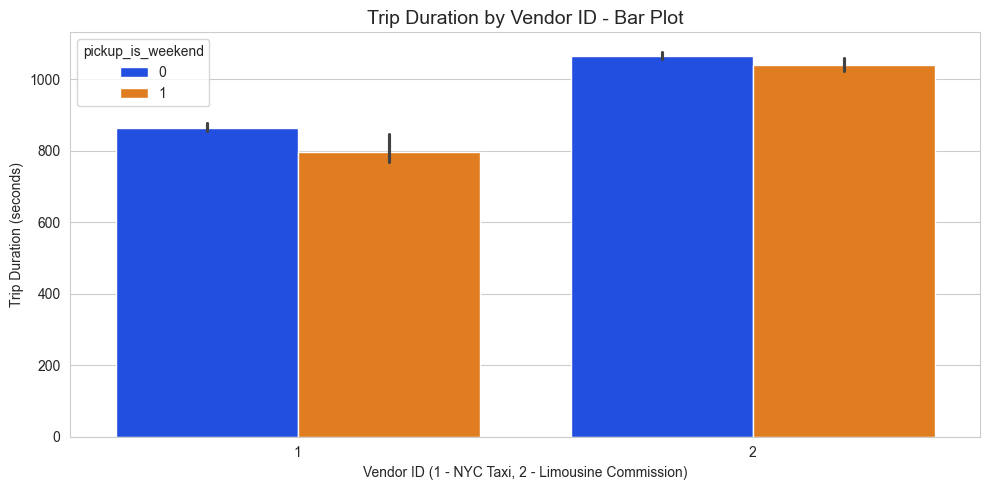

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.barplot(
    data=taxi_duration_df_copy_transformed_eda,
    x='vendor_id',
    y='trip_duration',
    hue='pickup_is_weekend',
    ax=ax,
)
ax.set_title(f'Trip Duration by Vendor ID - Bar Plot', fontsize=14)
ax.set_xlabel('Vendor ID (1 - NYC Taxi, 2 - Limousine Commission)')
ax.set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

No significant difference between trip duration based on Vendor ID And weekend status. Slightly faster trips are noticed on weekends, which is an observation made even in previous cases, with little correlation between Vendor ID and Weekend Status of the day. However, higher trip duration is noticed for Limousine Commission compared to NYC Taxi.

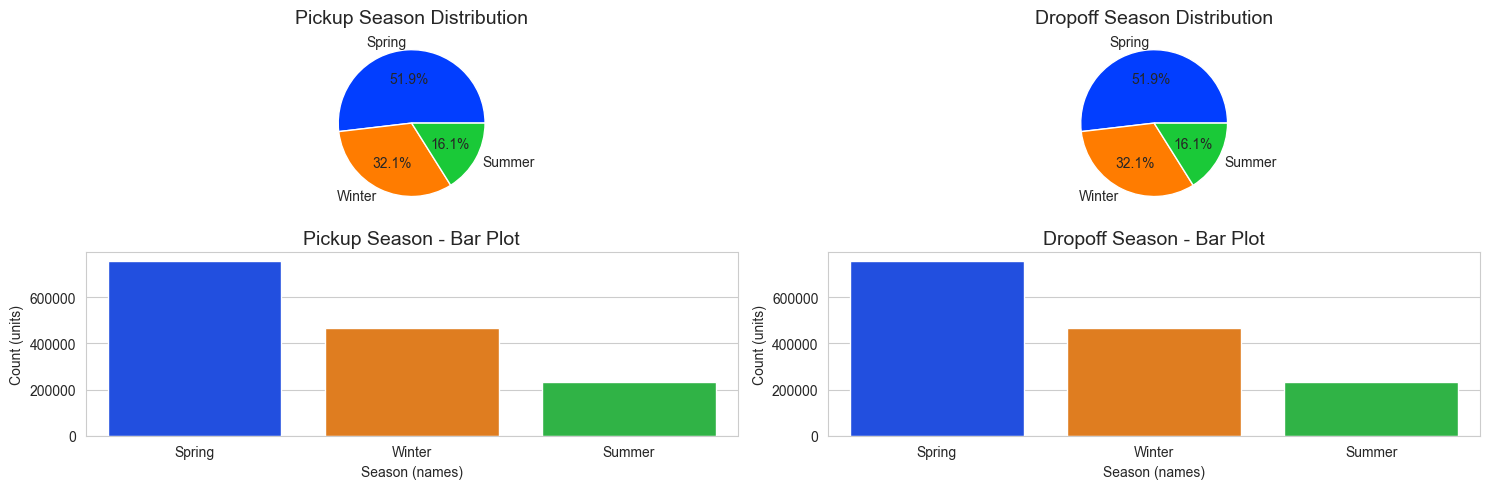

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(['pickup_season', 'dropoff_season']):
    counts = taxi_duration_df_copy_transformed_eda[col].value_counts()
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=sns.color_palette('bright', n_colors=len(counts))
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution', fontsize=14)

    sns.barplot(
        x=counts.index,
        y=counts.values,
        ax=axes[i + 2],
        palette='bright'
    )
    axes[i + 2].set_title(f'{col.replace("_", " ").title()} - Bar Plot', fontsize=14)
    axes[i + 2].set_xlabel('Season (names)')
    axes[i + 2].set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

No records of taxi trips from Autumn, which is strange. Most of the observations are from Spring Season, and lowest taxi trips were recorded in Summer. Further investigation is required to understand the relationships between other features and seasons.

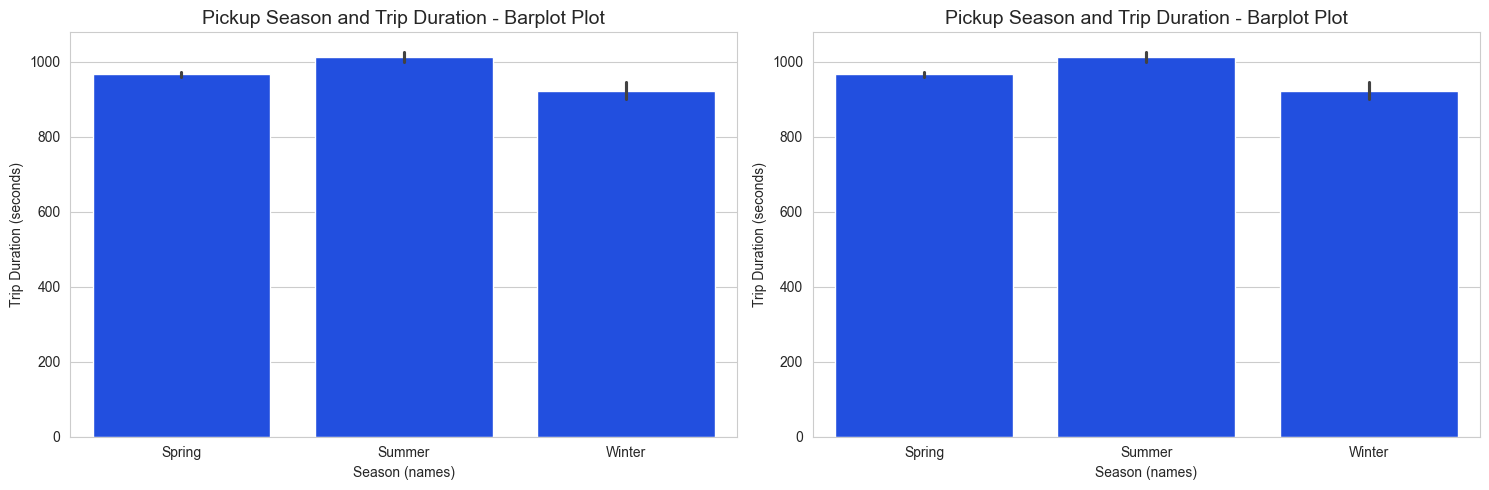

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_season', 'pickup_season']):
    sns.barplot(
        x=taxi_duration_df_copy_transformed_eda[col],
        y=taxi_duration_df_copy_transformed_eda['trip_duration'],
        ax=axes[i]
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} and Trip Duration - Barplot Plot', fontsize=14)
    axes[i].set_xlabel('Season (names)')
    axes[i].set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

Although lowest number of taxi trips are registered in Summer, this season is the one with the highest average trip duration, probably due to the highest number of people in traffic. On Winter, however, is the lowest trid duration of the taxi trips.

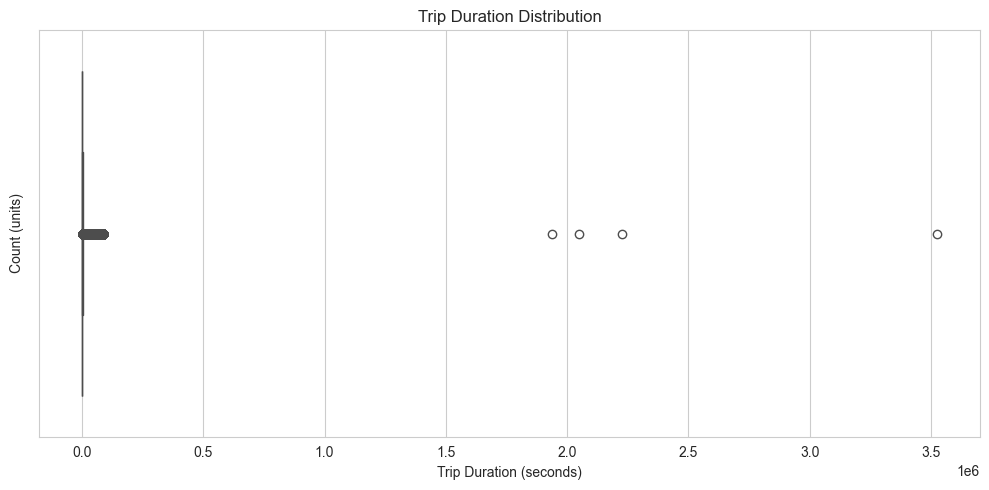

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.boxplot(data=taxi_duration_df_copy_transformed_eda, x='trip_duration', ax=ax)

ax.set_title('Trip Duration Distribution')
ax.set_xlabel('Trip Duration (seconds)')
ax.set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

Besides records with trip duration equal to zero, there are samples with incredibly high trip durations, which might show anomalies in the dataset, serving as outliers. For the purpose of EDA, was decided to use available Scikit-Learn Outlier Detection Methods and try to get rid of those sample points. But, for the beginning, a simple implementation of boxplot quartiles outlier detection method was done in order to have a basic representation of the data distribution of the target variable.

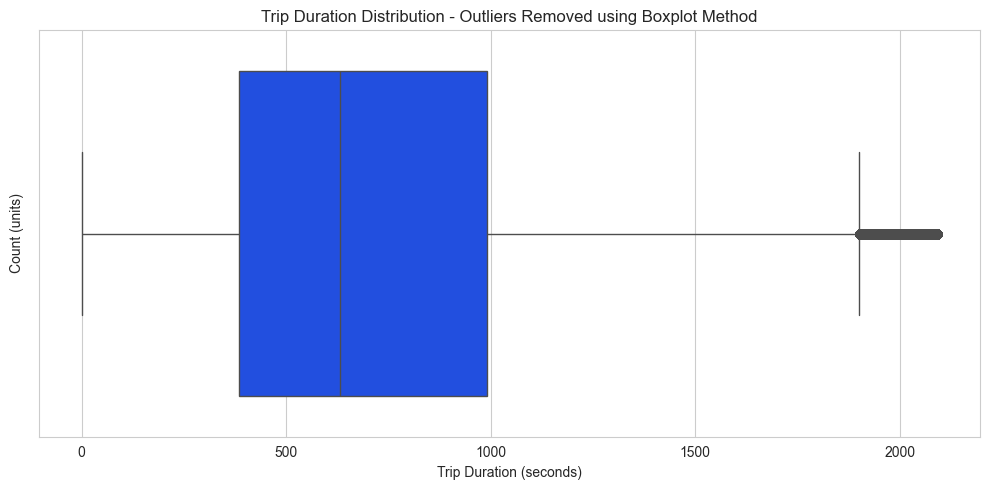

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(data=get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration'), x='trip_duration', ax=ax)

ax.set_title('Trip Duration Distribution - Outliers Removed using Boxplot Method')
ax.set_xlabel('Trip Duration (seconds)')
ax.set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

In [51]:
print(f"Number of Outliers removed using BoxPlot Method: {taxi_duration_df_copy_transformed_eda.shape[0] - get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration').shape[0]}")
print(f"Total Number of Taxi Trips: {taxi_duration_df_copy_transformed_eda.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using BoxPlot Method: {get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration').shape[0]}")
print(f"Percentage of Outliers removed using BoxPlot Method: {(taxi_duration_df_copy_transformed_eda.shape[0] - get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration').shape[0]) / taxi_duration_df_copy_transformed_eda.shape[0] * 100:.5f}%")
print(f"Percentage of Non-Outliers found using BoxPlot Method: {(get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration').shape[0] / taxi_duration_df_copy_transformed_eda.shape[0] * 100):.5f}%")

Number of Outliers removed using BoxPlot Method: 74220
Total Number of Taxi Trips: 1458644
Number of Non-Outlier Taxi Trips found using BoxPlot Method: 1384424
Percentage of Outliers removed using BoxPlot Method: 5.08829%
Percentage of Non-Outliers found using BoxPlot Method: 94.91171%


Now, the distribution is more clear, it is slightly skewed to low values. Median value is close to the center of the Interquartile Box. There are still outliers, but, hopefully, using advanced methods of outlier detection, it will be easier to get the appropriate amount of non-outlier data samples.

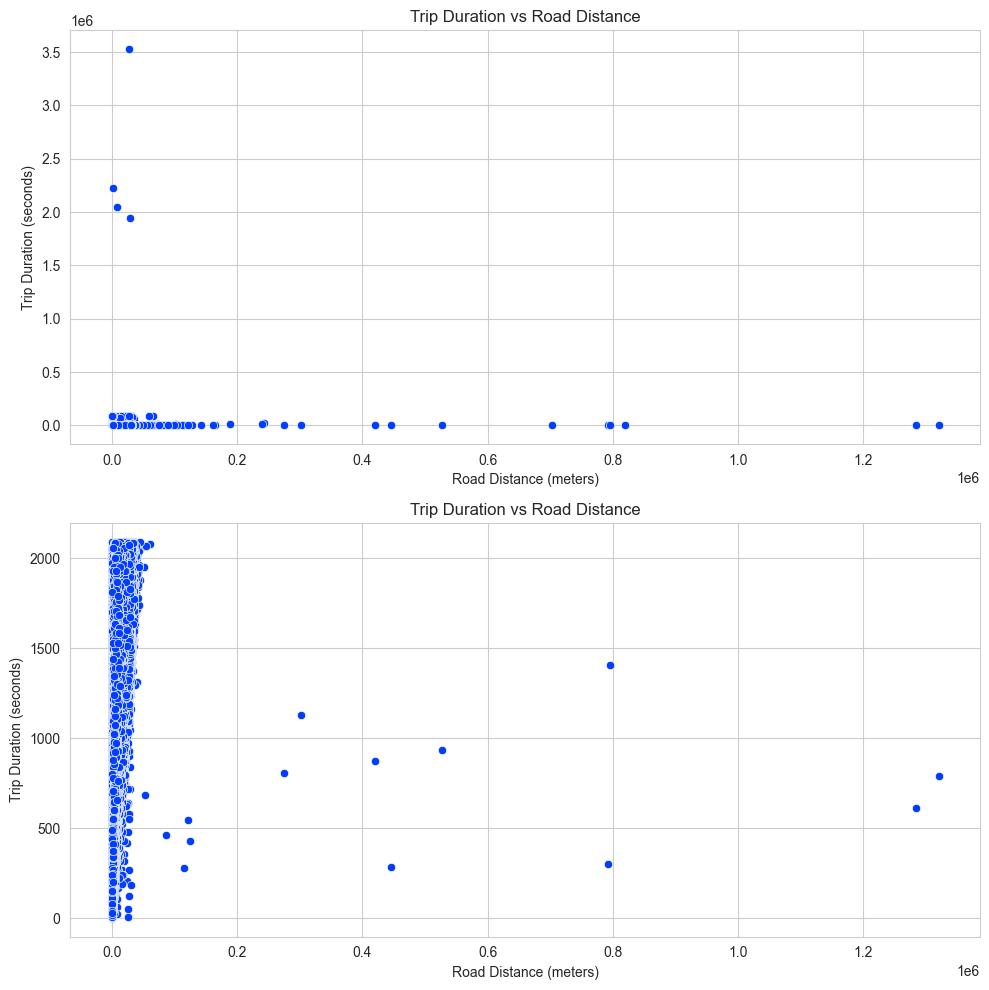

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i == 0:
        sns.scatterplot(data=taxi_duration_df_copy_transformed_eda, x='road_distance', y='trip_duration', ax=ax)
    else:
        sns.scatterplot(data=get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration'), x='road_distance', y='trip_duration', ax=ax)

    ax.set_title('Trip Duration vs Road Distance')
    ax.set_xlabel('Road Distance (meters)')
    ax.set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

As it may be noticed, there are samples that have very high Road Distance but Trip Duration, as well as inverse case - high Trip Duration, but very low Road Distance, which should be treated as anomalies. Most probably some passengers, during their trip, cancelled their ride, which could result in those problems, or driver forgot to disengage or engage their meter, which resulted in such anomalies. Per general, higher the road distance, higher the Trip Duration, which is quite logic, but there are still several factors that may come into play, such as: traffic load and so on.

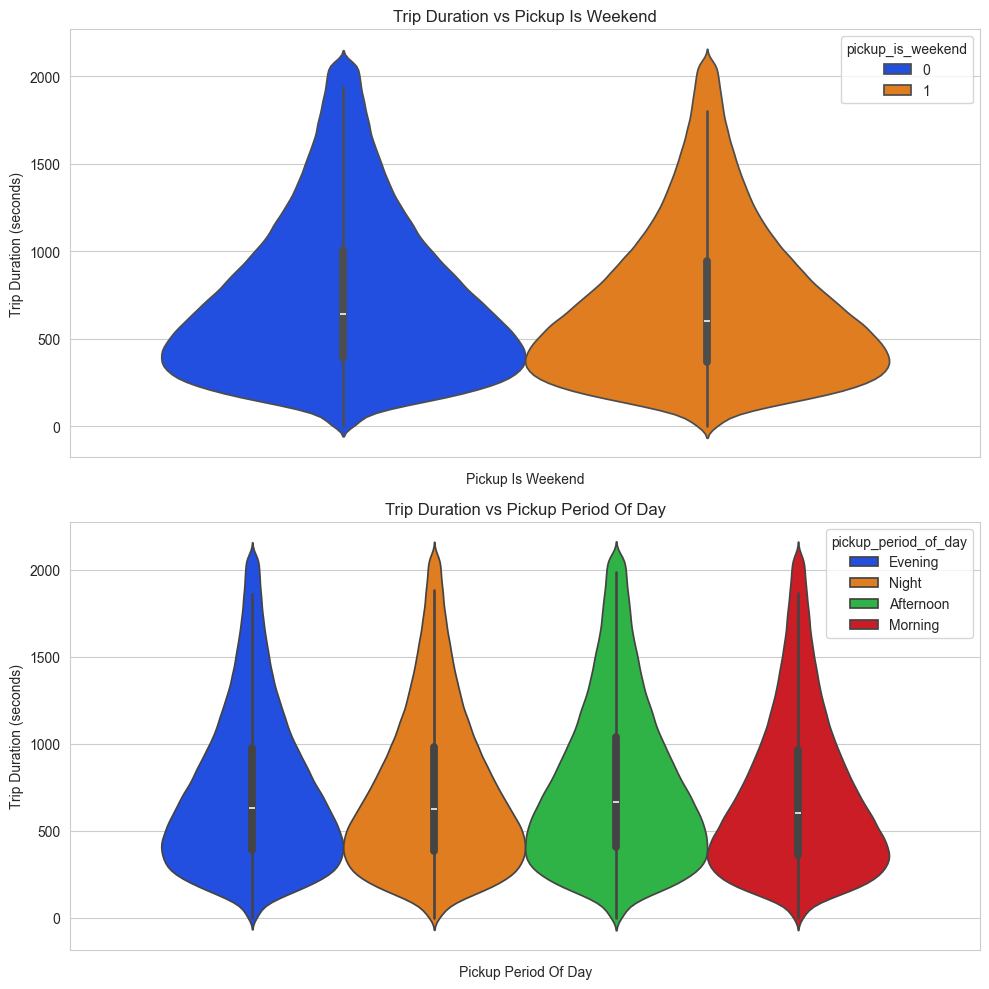

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i == 0:
        sns.violinplot(data=get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration'), hue='pickup_is_weekend', y='trip_duration', ax=ax)
    else:
        sns.violinplot(data=get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration'), hue='pickup_period_of_day', y='trip_duration', ax=ax)

    ax.set_title(f'Trip Duration vs {' '.join(word.title() for word in 'pickup_is_weekend'.split('_')) if i == 0 else ' '.join(word.title() for word in 'pickup_period_of_day'.split('_'))}')
    ax.set_xlabel(f'{' '.join(word.title() for word in 'pickup_is_weekend'.split('_')) if i == 0 else ' '.join(word.title() for word in 'pickup_period_of_day'.split('_'))}')
    ax.set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

These boxplots confirm the observation from above, on weekdays - traffic trip duration is higher and Afternoon and Night are the most overloaded and result in higher trip duration.

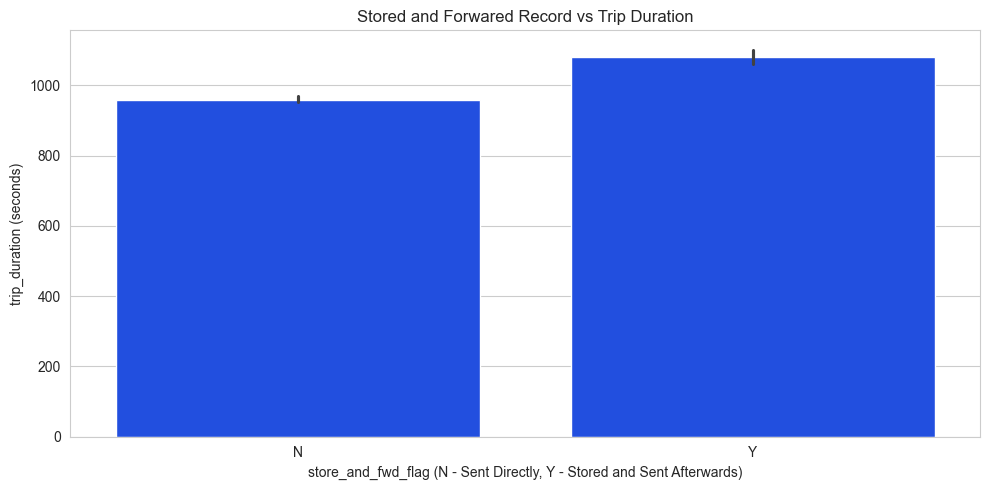

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.barplot(data=taxi_duration_df_copy_transformed_eda, 
            x='store_and_fwd_flag', 
            y='trip_duration', 
            ax=ax)

ax.set_title('Stored and Forwared Record vs Trip Duration')
ax.set_xlabel('store_and_fwd_flag (N - Sent Directly, Y - Stored and Sent Afterwards)')
ax.set_ylabel('trip_duration (seconds)')

plt.tight_layout()
plt.show()

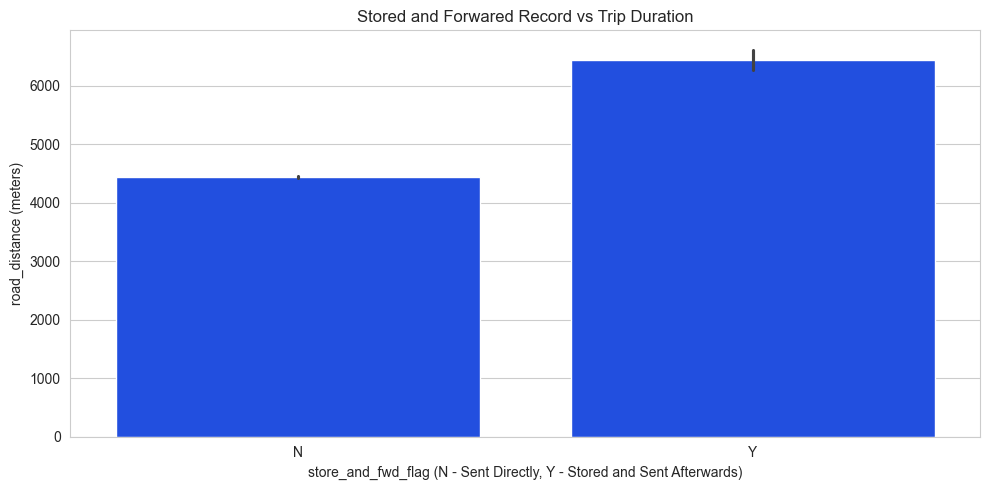

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.barplot(data=taxi_duration_df_copy_transformed_eda, 
            x='store_and_fwd_flag', 
            y='road_distance',
            ax=ax)

ax.set_title('Stored and Forwared Record vs Trip Duration')
ax.set_xlabel('store_and_fwd_flag (N - Sent Directly, Y - Stored and Sent Afterwards)')
ax.set_ylabel('road_distance (meters)')

plt.tight_layout()
plt.show()

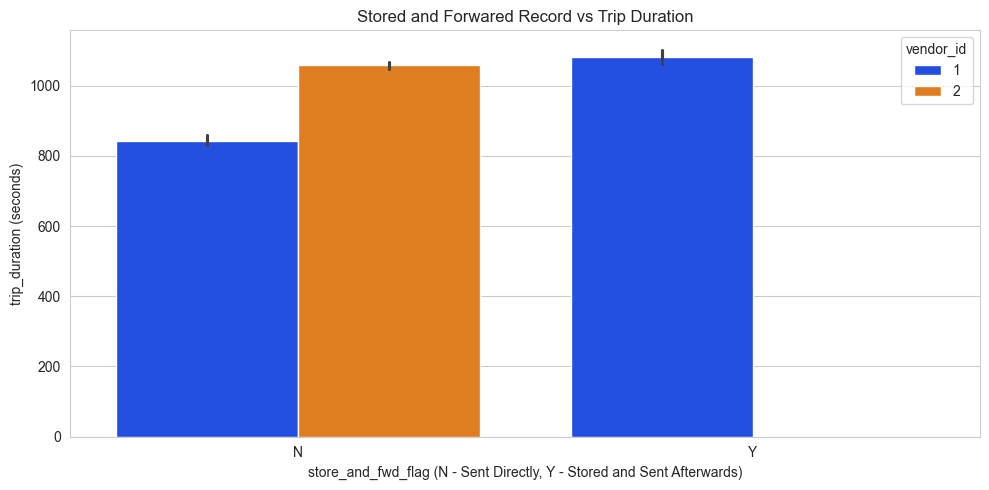

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.barplot(data=taxi_duration_df_copy_transformed_eda, 
            x='store_and_fwd_flag', 
            y='trip_duration',
            hue='vendor_id', 
            palette='bright',
            ax=ax)

ax.set_title('Stored and Forwared Record vs Trip Duration')
ax.set_xlabel('store_and_fwd_flag (N - Sent Directly, Y - Stored and Sent Afterwards)')
ax.set_ylabel('trip_duration (seconds)')

plt.tight_layout()
plt.show()


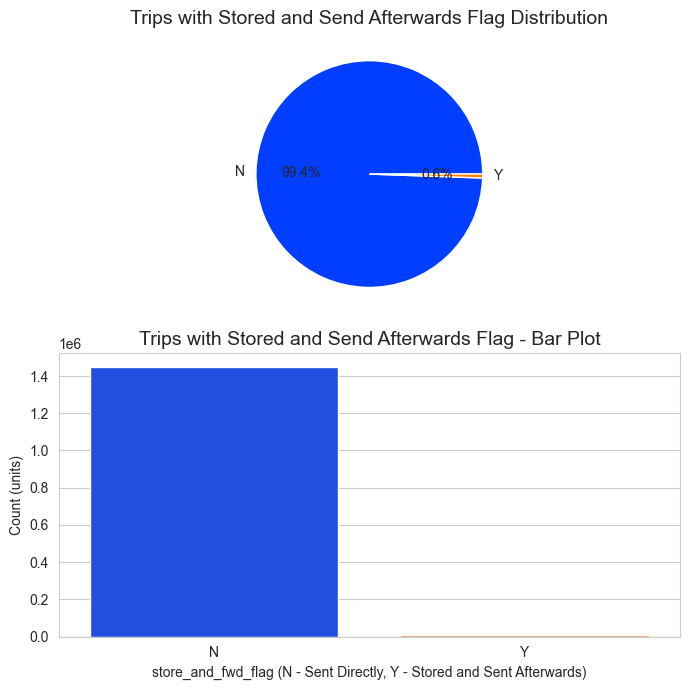

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
axes = axes.flatten()

counts = taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'].value_counts()
axes[0].pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('bright', n_colors=len(counts))
)
axes[0].set_title(f'Trips with Stored and Send Afterwards Flag Distribution', fontsize=14)

sns.barplot(
    x=counts.index,
    y=counts.values,
    ax=axes[1],
    palette='bright'
)
axes[1].set_title(f'Trips with Stored and Send Afterwards Flag - Bar Plot', fontsize=14)
axes[1].set_xlabel('store_and_fwd_flag (N - Sent Directly, Y - Stored and Sent Afterwards)')
axes[1].set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

In [58]:
print(f"Number of Taxi Trips with Store and Forward Flag: {taxi_duration_df_copy_transformed_eda[taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'] == 'Y'].shape[0]}")
print(f"Total Number of Taxi Trips: {taxi_duration_df_copy_transformed_eda.shape[0]}")
print(f"Percentage of Taxi Trips with Store and Forward Flag: {(taxi_duration_df_copy_transformed_eda[taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'] == 'Y'].shape[0] / taxi_duration_df_copy_transformed_eda.shape[0] * 100):.5f}%")
print(f"Number of Taxi Trips that were sent directly: {taxi_duration_df_copy_transformed_eda[taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'] == 'N'].shape[0]}")
print(f"Percentage of Taxi Trips that were sent directly: {(taxi_duration_df_copy_transformed_eda[taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'] == 'N'].shape[0] / taxi_duration_df_copy_transformed_eda.shape[0] * 100):.5f}%")

Number of Taxi Trips with Store and Forward Flag: 8045
Total Number of Taxi Trips: 1458644
Percentage of Taxi Trips with Store and Forward Flag: 0.55154%
Number of Taxi Trips that were sent directly: 1450599
Percentage of Taxi Trips that were sent directly: 99.44846%


As it may be seen, most of the taxi trips were sent directly to the company, rather than being stored and sent afterwards. This feature might not hold significant information about trip duration, therefore it might as well be dropped similarly to other columns discussed above. On the other hand, there is slight difference between the trip duration grouped by the status of the flag, however, due to the low amount of samples and imbalanced feature, this might not be the most accurate feature, but taken in consideration that for the records that were stored and sent afterwards, the route distance is significantly higher than for those sent directly to the vendor, the relationship might actually be true - records that were not sent directly but stored first and then sent to the agency might include mostly taxi trips with higher road distance and duration.

In [59]:
same_pickup_dropoff_mask = (
    (taxi_duration_df_copy_transformed_eda['pickup_latitude'] == taxi_duration_df_copy_transformed_eda['dropoff_latitude']) & 
    (taxi_duration_df_copy_transformed_eda['pickup_longitude'] == taxi_duration_df_copy_transformed_eda['dropoff_longitude'])
)

In [60]:
num_same_pickup_dropoff = same_pickup_dropoff_mask.sum()
print(f"Number of Taxi Trips with Same Pickup and Dropoff Location: {num_same_pickup_dropoff}")
print(f"Total Number of Taxi Trips: {taxi_duration_df_copy_transformed_eda.shape[0]}")
print(f"Percentage of Taxi Trips with Same Pickup and Dropoff Location: {(num_same_pickup_dropoff / taxi_duration_df_copy_transformed_eda.shape[0] * 100):.5f}%")

Number of Taxi Trips with Same Pickup and Dropoff Location: 5897
Total Number of Taxi Trips: 1458644
Percentage of Taxi Trips with Same Pickup and Dropoff Location: 0.40428%


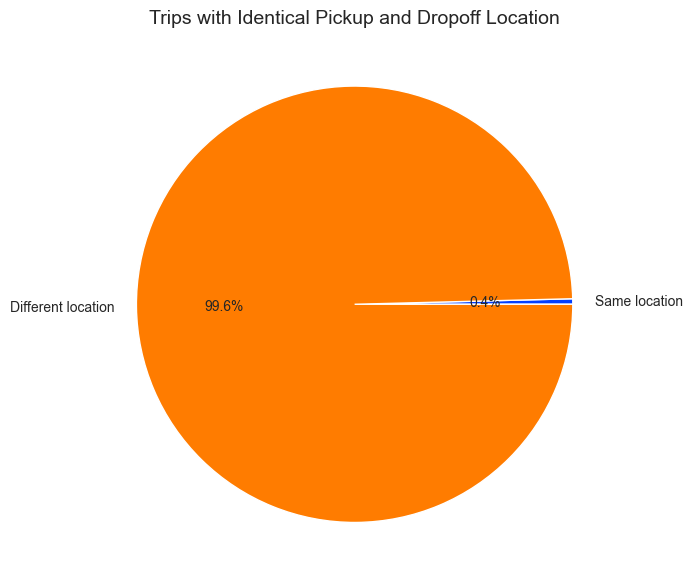

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

labels  = ['Same location', 'Different location']
sizes   = [num_same_pickup_dropoff, taxi_duration_df_copy_transformed_eda.shape[0] - num_same_pickup_dropoff]

ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=sns.color_palette('bright', n_colors=len(counts))
)
ax.set_title(f'Trips with Identical Pickup and Dropoff Location', fontsize=14)

plt.tight_layout()
plt.show()

Since there are records with same pickup and dropoff latitude and longitude, these records should be either dropped or their trip duration set to 0, in order to make model predict more accurate this case. However, there is a small percentage of this kind of trips, therefore they might be dropped.

## Missing Values
In order to understand better the dataset and be able to train a successful model, a missing values analysis should be done. This will help see if there are missing values in the dataset.

In [62]:
print(taxi_duration_df.isnull().sum())

id                       0
vendor_id                0
pickup_datetime          0
dropoff_datetime         0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
store_and_fwd_flag       0
trip_duration            0
road_distance            0
pickup_month             0
pickup_day               0
pickup_hour              0
pickup_period_of_day     0
pickup_is_weekend        0
pickup_season            0
dropoff_month            0
dropoff_day              0
dropoff_hour             0
dropoff_period_of_day    0
dropoff_is_weekend       0
dropoff_season           0
dtype: int64


No missing values were found in the dataset, therefore no imputation of null values should be done.

## Post-EDA Feature Enginering
Since EDA gave several useful insights into the dataset nature and variable distribution, a post-EDA Feature Engineering should be done. This includes manipulations with existing features, that might include the conversion from string categories to numerical values, in order to be used at model training step.

In [63]:
datetime_transformer_model_fe = FunctionTransformer(extract_datetime_features_fe, kw_args={'dt_cols': ['pickup_datetime']}, validate=False)
datetime_transformer_model_bp = FunctionTransformer(extract_datetime_features_bp, kw_args={'dt_cols': ['pickup_datetime']}, validate=False)

In [64]:
def remove_same_location_rows(X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame | tuple[pd.DataFrame, pd.Series]:
    same_pickup_dropoff_mask = (
        (X['pickup_latitude'] == X['dropoff_latitude']) & 
        (X['pickup_longitude'] == X['dropoff_longitude'])
    )
    if y is not None:
        return X[~same_pickup_dropoff_mask], y[~same_pickup_dropoff_mask]
    else:
        return X[~same_pickup_dropoff_mask]

In [65]:
drop_same_location_transformer = FunctionTransformer(remove_same_location_rows, validate=False)

In [66]:
transformer_dropper_first = ColumnTransformer([
    ('drop', 'drop', ['dropoff_datetime', 'id'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [67]:
transformer_convertor = ColumnTransformer([
    ('datetime', datetime_transformer_model_fe, ['pickup_datetime']),
    ('distance', distance_transformer, location_columns),
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [68]:
transformer_dropper = ColumnTransformer([
    ('drop', 'drop', ['pickup_datetime'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [69]:
encoder_transformer = ColumnTransformer([
    ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
    ('encode', OrdinalEncoder(), ['pickup_season', 'pickup_period_of_day']),
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [70]:
pipeline = Pipeline(
    steps=[
        ('drop_first', transformer_dropper_first),
        ('remove_same_location', drop_same_location_transformer),
        ('feature_engineering', transformer_convertor),
        ('drop_columns', transformer_dropper),
        ('encoder', encoder_transformer),
    ]
).set_output(transform='pandas')

In [71]:
taxi_duration_df_copy_transformed = pipeline.fit_transform(taxi_duration_df_copy)

Convert pickup_datetime to DateTime:   0%|          | 0/1452747 [00:00<?, ?it/s]

Convert pickup_datetime to DateTime:   0%|          | 0/1452747 [00:00<?, ?it/s]

Convert pickup_datetime to DateTime:   0%|          | 0/1452747 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [72]:
taxi_duration_df_copy_transformed

store_and_fwd_flag_Y  pickup_season  ...  passenger_count  trip_duration
0                         0.0            0.0  ...                1            455
1                         0.0            1.0  ...                1            663
2                         0.0            2.0  ...                1           2124
3                         0.0            0.0  ...                1            429
4                         0.0            0.0  ...                1            435
...                       ...            ...  ...              ...            ...
1458639                   0.0            0.0  ...                4            778
1458640                   0.0            2.0  ...                1            655
1458641                   0.0            0.0  ...                1            764
1458642                   0.0            2.0  ...                1            373
1458643                   0.0            0.0  ...                1            198

[1452747 rows x 15 columns]

## Feature Selection
In order to avoid multicollinearity and high-dimensionality of the dataset, Feature Selection may be used. For example, there are several methods of detecting the most important features, avoiding 'useless' features.

### P-Value Based Selector


In [73]:
pvalue_selector = PValueSelector()
selected_columns_pvalue = pvalue_selector.select(dataframe=taxi_duration_df_copy_transformed, y_column='trip_duration')
selected_columns_pvalue

['pickup_period_of_day',
 'pickup_month',
 'pickup_day',
 'pickup_hour',
 'pickup_is_weekend',
 'pickup_longitude',
 'dropoff_latitude',
 'road_distance',
 'vendor_id',
 'passenger_count']

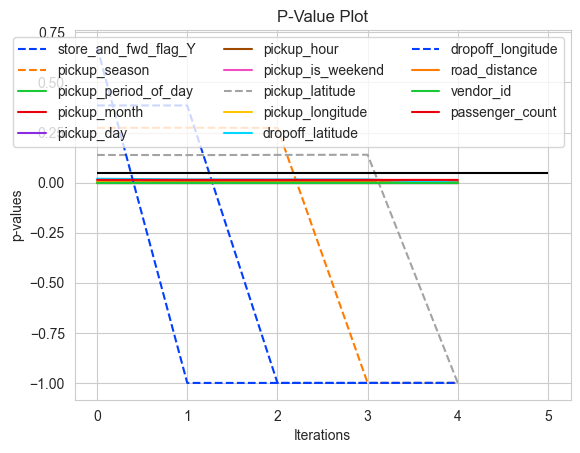

In [74]:
pvalue_selector.plot_process()

### Correlation Matrix

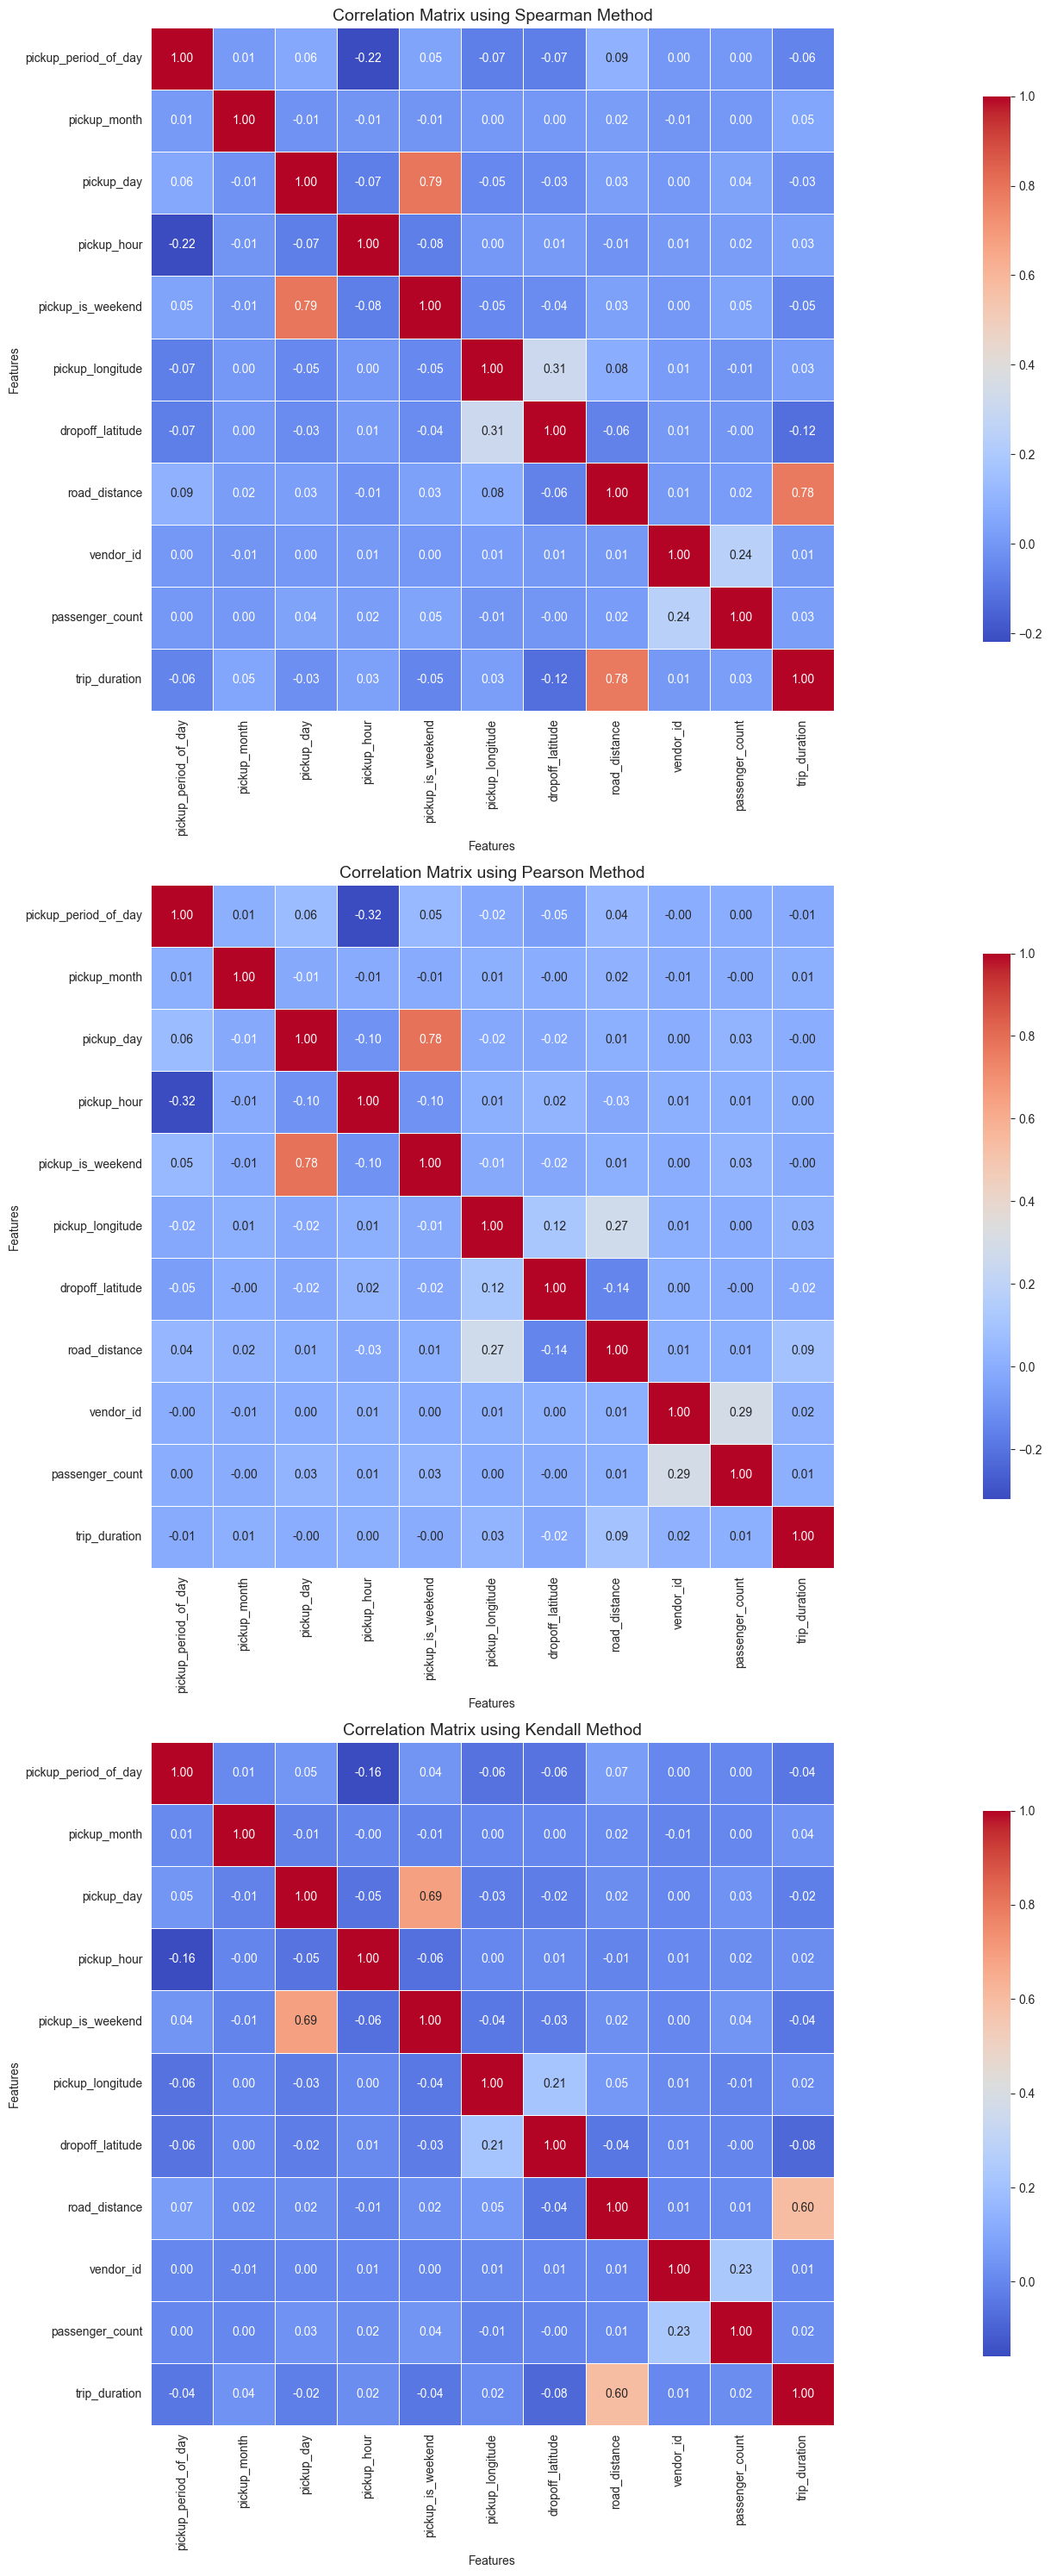

In [75]:
methods = ['spearman', 'pearson', 'kendall']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(35, 30))
axes = axes.flatten()

for i, method in enumerate(methods):
    corr_matrix = taxi_duration_df_copy_transformed[selected_columns_pvalue + ['trip_duration']].corr(method=method)

    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        cbar_kws={'shrink': 0.8},
        linewidths=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f'Correlation Matrix using {method.capitalize()} Method', fontsize=14)
    axes[i].set_xlabel('Features')
    axes[i].set_ylabel('Features')

plt.tight_layout()
plt.show()

## Model Selection

For the models, were analyzed the following options:
1. **Random Forest Regressor**, since it is robust to outliers and does not require scaling of the features to be done;
2. **XGBoost**, similar concept as Random Forest, but different implementation. It builds sequentially Decision Trees and each new tree corrects errors made by the previous ones. It is suitable when the dataset is large, as it is a fast algorithm, again - robust to outliers and feature scale;
3. **LightGBM**, similar to XGBoost, with slightly different tree building mechanism, faster training time, but less likely to find a generalized model and is less robust to outliers and noise in dataset.
3. **Linear Regression** - the most basic regressor, find the best fit line, offers fast computations and straight-forward interpretation of the results;
4. **Support Vector Machine** - powerful ML Model, but it requires data be standardized, which expects the data adhere to Gaussian Distribution. However, as it was described above, not all features are following this distribution. At the same time, SVMs are not the best suitable solution for large datasets, since it is computationally intensive and its training may take a lot of time;
5. **K-Nearest Neighbors Regressor** - again, very computational intensive algorithm, that requires constant calculations of the distances between points. Thus, it is not the best option suitable for this task.

Were selected the following models due to their fast training speed and handling of large datasets, as well as, specifically for LightGBM and XGBoost, which are built upon Random Forest Regressor Model, with addition of different logic behind prediction making and optimized handling of tabular data:
1. **LightGBM**;
2. **XGBoost**;
3. **Linear Regression**.

## Model Training - Baseline Performance

In order to observe the efficiency of planned manipulations with dataset and model training and to compare it with the default model behavior on the minimally edited dataset, that will ensure compatibility with model fit and predict methods, a training a model with default parameters is used, which is known as baseline performance.

In [76]:
def create_pipeline(steps: list[tuple[str, BaseEstimator]]) -> Pipeline:
    return Pipeline(steps=steps).set_output(transform='pandas')

#### Preparation of the subsets

1. `_zip` - only `train.csv` is used, for local score determination, model is trained on a subset of the Kaggle training set;
2. `_sub` - both `train.csv` and `test.csv` are used, for Kaggle submission of the predictions.

In [77]:
taxi_training_df = pd.read_csv('dataset/train.csv')
taxi_test_df = pd.read_csv('dataset/test.csv')

In [78]:
taxi_subset_training_df, taxi_subset_test_df = train_test_split(taxi_training_df, test_size=0.2, random_state=42)

In [79]:
X_train_zip, X_test_zip, y_train_zip, y_test_zip = train_test_split(
    taxi_subset_training_df.drop(columns=['trip_duration']),
    taxi_subset_training_df['trip_duration'],
    test_size=0.2,
    random_state=42
)

In [80]:
X_train_sub = taxi_training_df.drop(columns=['trip_duration'])
y_train_sub = taxi_training_df['trip_duration']
X_test_sub = taxi_test_df

##### Log Transformation
Since `trip_duration` column is very skewed, was suggested to perfom log transformation in order to compensate this and bring to more normal distribution

In [81]:
y_train_zip_log = pd.Series(np.log1p(y_train_zip), 
                               index=X_train_zip.index, 
                               name='trip_duration'
                               )
y_test_zip_log = pd.Series(np.log1p(y_test_zip), 
                               index=X_test_zip.index, 
                               name='trip_duration'
                               )

In [82]:
y_train_sub_log = pd.Series(np.log1p(y_train_sub), 
                               index=X_train_sub.index, 
                               name='trip_duration'
                               )

##### Basic Transformations
Below are Transformers that are slightly changing the dataset in order to make model training possible (`DateTime` conversion and extraction of hour, day and month, encoding `store_and_fwd_flag` binary feature, dropping original `DateTime` columns)

In [83]:
transformer_dropper_first = ColumnTransformer([
    ('drop', 'drop', ['id', 'dropoff_datetime'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

transformer_convertor = ColumnTransformer([
    ('datetime', datetime_transformer_model_bp, ['pickup_datetime'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

transformer_dropper = ColumnTransformer([
    ('drop', 'drop', ['pickup_datetime'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

encoder_transformer = ColumnTransformer([
    ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [84]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [85]:
baseline_engineering_pipeline = create_pipeline(steps=pipeline_steps)

In [86]:
X_train_zip_bp = baseline_engineering_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_bp = baseline_engineering_pipeline.transform(X=X_test_zip)

In [87]:
baseline_engineering_pipeline = create_pipeline(steps=pipeline_steps)

In [88]:
X_train_sub_bp = baseline_engineering_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_bp = baseline_engineering_pipeline.transform(X=X_test_sub)

### Light Gradient Boost Model (LightGBM)

In [89]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [90]:
lightgbm_regressor.fit(X=X_train_zip_bp, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851873
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.12 MB) transferred to GPU in 0.013929 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [91]:
y_hat_zip_bp_log = lightgbm_regressor.predict(X=X_test_zip_bp)
y_hat_zip_bp = pd.Series(np.expm1(y_hat_zip_bp_log),
                         index=X_test_zip_bp.index,
                         name='trip_duration'
                         )

In [92]:
y_hat_zip_bp[y_hat_zip_bp < 0]

Series([], Name: trip_duration, dtype: float64)

In [93]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")

MAE: 344.14
MSE: 10190101.11
RMSE: 3192.19
R2: 0.03
RMSLE: 0.49


In [94]:
pd.concat([y_test_zip, y_hat_zip_bp], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  491.868615
702763      524  661.921178
1094869     256  382.501932
348453      528  669.012387
445599     1164  824.016198
...         ...         ...
762043     1036  597.471908
731741     1097  797.783217
285926      374  357.642808
887221      545  463.164389
938122      479  571.487300

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [95]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [96]:
lightgbm_regressor.fit(X=X_train_sub_bp, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851738
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.13 MB) transferred to GPU in 0.020838 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [97]:
y_hat_sub_bp_log = lightgbm_regressor.predict(X=X_test_sub_bp)
y_hat_sub_bp = pd.Series(np.expm1(y_hat_sub_bp_log),
                         index=X_test_sub_bp.index,
                         name='trip_duration'
                         )

In [98]:
y_hat_sub_bp[y_hat_sub_bp < 0]

Series([], Name: trip_duration, dtype: float64)

In [99]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_bp})

df_submission.to_csv(f'dataset/submission_default_bp_lightgbm.csv', index=False)

Kaggle Score: `0.49362 | 0.49384`

### eXtreme Gradient Boosting (XGBoost)

In [100]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [101]:
xgboost_regressor.fit(X=X_train_zip_bp, y=y_train_zip_log)

[10:20:07] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 10, 9335320).
[10:20:07] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [102]:
y_hat_zip_bp_log = xgboost_regressor.predict(X=X_test_zip_bp)
y_hat_zip_bp = pd.Series(np.expm1(y_hat_zip_bp_log),
                         index=X_test_zip_bp.index,
                         name='trip_duration'
                         )

d:\Programming\Projects\Sigmoid\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [10:20:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [103]:
y_hat_zip_bp[y_hat_zip_bp < 0]

Series([], Name: trip_duration, dtype: float32)

In [104]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")

MAE: 319.81
MSE: 10161021.00
RMSE: 3187.64
R2: 0.03
RMSLE: 0.44


In [105]:
pd.concat([y_test_zip, y_hat_zip_bp], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   495.946686
702763      524   599.166016
1094869     256   447.078125
348453      528   674.909302
445599     1164  1067.107056
...         ...          ...
762043     1036   811.168640
731741     1097  1315.331909
285926      374   325.218719
887221      545   502.147736
938122      479   507.127045

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [106]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [107]:
xgboost_regressor.fit(X=X_train_sub_bp, y=y_train_sub_log)

[10:20:09] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 10, 14586440).
[10:20:09] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [108]:
y_hat_sub_bp_log = xgboost_regressor.predict(X=X_test_sub_bp)
y_hat_sub_bp = pd.Series(np.expm1(y_hat_sub_bp_log),
                         index=X_test_sub_bp.index,
                         name='trip_duration'
                         )

In [109]:
y_hat_sub_bp[y_hat_sub_bp < 0]

Series([], Name: trip_duration, dtype: float32)

In [110]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_bp})

df_submission.to_csv(f'dataset/submission_default_bp_xgboost.csv', index=False)

Kaggle Score: `0.44603 | 0.44743`

### Linear Regression

In [111]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [112]:
linear_regressor.fit(X=X_train_zip_bp, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [113]:
y_hat_zip_bp_log = linear_regressor.predict(X=X_test_zip_bp)
y_hat_zip_bp = pd.Series(np.expm1(y_hat_zip_bp_log),
                         index=X_test_zip_bp.index,
                         name='trip_duration'
                         )

In [114]:
y_hat_zip_bp[y_hat_zip_bp < 0]

Series([], Name: trip_duration, dtype: float64)

In [115]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")

MAE: 280992927.38
MSE: 18427154898525291020288.00
RMSE: 135746657043.65
R2: -1755100328676251.50
RMSLE: 0.78


In [116]:
pd.concat([y_test_zip, y_hat_zip_bp], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  606.610203
702763      524  626.301930
1094869     256  589.059601
348453      528  723.569871
445599     1164  541.707736
...         ...         ...
762043     1036  597.012931
731741     1097  648.309009
285926      374  646.754471
887221      545  632.042860
938122      479  657.599804

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [117]:
linear_regressor.fit(X=X_train_sub_bp, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [118]:
y_hat_sub_bp_log = linear_regressor.predict(X=X_test_sub_bp)
y_hat_sub_bp = pd.Series(np.expm1(y_hat_sub_bp_log),
                         index=X_test_sub_bp.index,
                         name='trip_duration'
                         )

In [119]:
y_hat_sub_bp[y_hat_sub_bp < 0]

324125   -1.000000
380737   -0.653288
483163   -0.999569
512346   -0.999805
Name: trip_duration, dtype: float64

In [120]:
y_hat_sub_bp[y_hat_sub_bp < 0] = 0

In [121]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_bp})

df_submission.to_csv(f'dataset/submission_default_bp_linear.csv', index=False)

Kaggle Score: `0.77683 | 0.77470`

In [122]:
del baseline_engineering_pipeline, X_train_zip_bp, X_test_zip_bp, X_train_sub_bp, X_test_sub_bp, y_hat_sub_bp_log, y_hat_sub_bp, y_hat_zip_bp_log, y_hat_zip_bp

## Model Training - Drop Same Location Trips

Further is presented the models training process with the addition of a new step in the pipeline - removal of same location trips (same pickup and dropoff latitude and longitude).

In [123]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('drop_same_location', drop_same_location_transformer),
    ('datetime_transformation', transformer_convertor),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [124]:
def match_X_y(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.Series]:
    common_index = X.index.intersection(y.index)
    return X.loc[common_index], y.loc[common_index]

In [125]:
def indices_match_rowwise(X: pd.DataFrame, y: pd.Series) -> bool:
    return X.index.equals(y.index)

In [126]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [127]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline[0].transform(X=X_test_zip)  # Avoid dropping same location rows in test set

In [128]:
X_test_zip_tf.shape[0]

233383

In [129]:
X_test_zip_tf = transformation_pipeline[2:].transform(X=X_test_zip_tf)  # Avoid dropping same location rows in test set

In [130]:
X_test_zip_tf.shape[0]

233383

In [131]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [132]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline[0].transform(X=X_test_sub)  # Avoid dropping same location rows in test set

In [133]:
X_test_sub_tf.shape[0]

625134

In [134]:
X_test_sub_tf = transformation_pipeline[2:].transform(X=X_test_sub_tf)  # Avoid dropping same location rows in test set

In [135]:
X_test_sub_tf.shape[0] 

625134

##### Match target variable indices and shape with features

In [136]:
y_train_zip_tf_log = match_X_y(X=X_train_zip_tf, y=y_train_zip_log)[1]

In [137]:
y_train_zip_tf = pd.Series(np.expm1(y_train_zip_tf_log),
                          index=X_train_zip_tf.index,
                          name='trip_duration'
                          )

In [138]:
y_train_sub_tf_log = match_X_y(X=X_train_sub_tf, y=y_train_sub_log)[1]

In [139]:
y_train_sub_tf = pd.Series(np.expm1(y_train_sub_tf_log),
                          index=X_train_sub_tf.index,
                          name='trip_duration'
                          )

In [140]:
print(f"Train zip X, y match: {indices_match_rowwise(X=X_train_zip_tf, y=y_train_zip_tf_log)}")
print(f"Train sub X, y match: {indices_match_rowwise(X=X_train_sub_tf, y=y_train_sub_tf_log)}")

Train zip X, y match: True
Train sub X, y match: True


### Light Gradient Boost Model (LightGBM)

In [141]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [142]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851047
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 929782, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.09 MB) transferred to GPU in 0.013369 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.471898
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [143]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [144]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [145]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 342.80
MSE: 10187564.65
RMSE: 3191.80
R2: 0.03
RMSLE: 0.49


In [146]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  495.652993
702763      524  624.766559
1094869     256  445.055759
348453      528  612.691994
445599     1164  890.351951
...         ...         ...
762043     1036  651.432198
731741     1097  787.139351
285926      374  344.440896
887221      545  457.802122
938122      479  588.057565

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [147]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [148]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851252
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 1452747, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.08 MB) transferred to GPU in 0.021200 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.472101
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [149]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [150]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [151]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_dropSameLoc_default_lightgbm.csv', index=False)

Kaggle Score: `0.49864 | 0.49911`

### eXtreme Gradient Boosting (XGBoost)

In [152]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [153]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

[10:20:28] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (929782, 10, 9297820).
[10:20:28] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [154]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [155]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [156]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 319.80
MSE: 10161124.00
RMSE: 3187.65
R2: 0.03
RMSLE: 0.44


In [157]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   460.976624
702763      524   693.773438
1094869     256   344.455017
348453      528   725.375488
445599     1164  1250.504883
...         ...          ...
762043     1036   720.241211
731741     1097  1241.421265
285926      374   348.335358
887221      545   571.366577
938122      479   540.653625

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [158]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [159]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

[10:20:29] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1452747, 10, 14527470).
[10:20:29] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [160]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [161]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [162]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_dropSameLoc_default_xgboost.csv', index=False)

Kaggle Score: `0.44859 | 0.45007`

### Linear Regression

In [163]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [164]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [165]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [166]:
y_hat_zip_tf[y_hat_zip_tf < 0]

1100676   -0.540551
Name: trip_duration, dtype: float64

In [167]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [168]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 65606826676.03
MSE: 1004540092651525900723027968.00
RMSE: 31694480476125.90
R2: -95677746048700284928.00
RMSLE: 0.78


In [169]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  605.310522
702763      524  632.435524
1094869     256  568.073816
348453      528  738.845965
445599     1164  534.830731
...         ...         ...
762043     1036  588.586303
731741     1097  667.776165
285926      374  657.347029
887221      545  632.266101
938122      479  669.955384

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [170]:
linear_regressor = LinearRegression(n_jobs=-1)

In [171]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [172]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [173]:
y_hat_sub_tf[y_hat_sub_tf < 0]

324125   -1.000000
380737   -0.902688
483163   -0.999971
512346   -0.999974
Name: trip_duration, dtype: float64

In [174]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [175]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_dropSameLoc_default_linearRegr.csv', index=False)

Kaggle Score: `0.77546 | 0.77320`

## Model Training - Same Location = Zero trip duration

Also, another approach to handle trips with same location of pickup and dropoff is to set their trip duration to 0, such that will make model pick up relationships more accurate to this logic assumption.

In [176]:
def zero_same_location_rows(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.Series]:
    same_pickup_dropoff_mask = (
        (X['pickup_latitude'] == X['dropoff_latitude']) & 
        (X['pickup_longitude'] == X['dropoff_longitude'])
    )
    indices = X[same_pickup_dropoff_mask].index
    y_copy = y.copy()
    y_copy.loc[indices] = 0
    return y_copy

In [177]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [178]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [179]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

In [180]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [181]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

##### Zero `trip_duration` for Same Location Trips

In [182]:
zip_same_location_indices_mask = X_train_zip_tf[
    (
        (X_train_zip_tf['pickup_latitude'] == X_train_zip_tf['dropoff_latitude']) & 
        (X_train_zip_tf['pickup_longitude'] == X_train_zip_tf['dropoff_longitude'])
    )
].index

In [183]:
sub_same_location_indices_mask = X_train_sub_tf[
    (
        (X_train_sub_tf['pickup_latitude'] == X_train_sub_tf['dropoff_latitude']) & 
        (X_train_sub_tf['pickup_longitude'] == X_train_sub_tf['dropoff_longitude'])
    )
].index

In [184]:
y_train_zip_log.loc[zip_same_location_indices_mask]

1367006    7.145984
362772     5.713733
445120     7.247793
363515     5.988961
472816     5.347108
             ...   
930022     6.411818
855635     3.178054
1039453    1.386294
1205566    3.583519
626487     5.686975
Name: trip_duration, Length: 3750, dtype: float64

In [185]:
y_train_zip_tf_log = zero_same_location_rows(X=X_train_zip_tf, y=y_train_zip_log)

In [186]:
y_train_zip_tf_log.loc[zip_same_location_indices_mask]

1367006    0.0
362772     0.0
445120     0.0
363515     0.0
472816     0.0
          ... 
930022     0.0
855635     0.0
1039453    0.0
1205566    0.0
626487     0.0
Name: trip_duration, Length: 3750, dtype: float64

In [187]:
y_train_sub_tf_log = zero_same_location_rows(X=X_train_sub_tf, y=y_train_sub_log)

### Light Gradient Boost Model (LightGBM)

In [188]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [189]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851873
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.12 MB) transferred to GPU in 0.012045 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.445900
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [190]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [191]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [192]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 344.84
MSE: 10193038.80
RMSE: 3192.65
R2: 0.03
RMSLE: 0.49


In [193]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  488.563882
702763      524  595.384464
1094869     256  397.991704
348453      528  645.531677
445599     1164  997.725675
...         ...         ...
762043     1036  597.200997
731741     1097  855.566805
285926      374  332.768991
887221      545  436.043108
938122      479  566.265451

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [194]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851738
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.13 MB) transferred to GPU in 0.019627 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.445936
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [195]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [196]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [197]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_zeroSameLoc_default_lightgbm.csv', index=False)

Kaggle Score: `0.49918 | 0.49919`

### eXtreme Gradient Boosting (XGBoost)

In [198]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [199]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

[10:20:47] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 10, 9335320).
[10:20:47] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [200]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [201]:
y_hat_zip_tf[y_hat_zip_tf < 0]

292356    -0.522732
258670    -0.158526
315344    -0.023798
1166964   -0.405960
821097    -0.355904
Name: trip_duration, dtype: float32

In [202]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [203]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 325.04
MSE: 10169921.00
RMSE: 3189.03
R2: 0.03
RMSLE: 0.46


In [204]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   371.951447
702763      524   597.919861
1094869     256   362.555237
348453      528   654.287781
445599     1164  1120.766357
...         ...          ...
762043     1036   671.804688
731741     1097  1182.308716
285926      374   291.781799
887221      545   581.743042
938122      479   518.980042

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [205]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [206]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

[10:20:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 10, 14586440).
[10:20:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [207]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [208]:
y_hat_sub_tf[y_hat_sub_tf < 0]

32920    -0.674973
45865    -0.365091
46476    -0.283551
234974   -0.487580
235389   -0.712497
267395   -0.285566
267480   -0.304079
314228   -0.350760
315041   -0.482388
349244   -0.210610
490041   -0.015309
523431   -0.063218
562314   -0.141632
Name: trip_duration, dtype: float32

In [209]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [210]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_zeroSameLoc_default_xgboost.csv', index=False)

Kaggle Score: `0.46247 | 0.46305`

### Linear Regression

In [211]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [212]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [213]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [214]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [215]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 68315301.60
MSE: 1089176217225650110464.00
RMSE: 33002669849.96
R2: -103738941109789.14
RMSLE: 0.78


In [216]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  599.369158
702763      524  608.832868
1094869     256  577.159340
348453      528  712.708694
445599     1164  537.554418
...         ...         ...
762043     1036  582.168561
731741     1097  627.645937
285926      374  628.397689
887221      545  615.442208
938122      479  648.336289

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [217]:
linear_regressor = LinearRegression(n_jobs=-1)

In [218]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [219]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [220]:
y_hat_sub_tf[y_hat_sub_tf < 0]

324125   -1.000000
380737   -0.335303
483163   -0.998921
512346   -0.999678
Name: trip_duration, dtype: float64

In [221]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [222]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_zeroSameLoc_default_linearRegr.csv', index=False)

Kaggle Score: `0.77796 | 0.77590`

## Model Training - Outlier Removal

In order to detect outliers (data points that differs extremely from other observations within a dataset), there are different models, such as:
1. **Isolation Forest** - implements Random Forest Model in order to detect anomaly points, by finding points that are "isolated" via shorter paths in the collective Tree Structures.
2. **Local Outlier Factor** - computes the local density deviation of a given data point with respect to its neighbors.

In [223]:
outlier_detectors = [
    IsolationForest(n_jobs=-1, random_state=42, contamination=0.01),
    LocalOutlierFactor(n_jobs=-1, n_neighbors=20, novelty=False, contamination=0.01),
]

In [224]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [225]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [226]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

In [227]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [228]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

#### Outlier Detection - Isolation Forest

In [229]:
isolation_forest_detector = outlier_detectors[0]

In [230]:
X_train_zip_tf_outliers = isolation_forest_detector.fit_predict(X=X_train_zip_tf, y=y_train_zip_log)
X_train_zip_tf_outliers = pd.Series(X_train_zip_tf_outliers, index=X_train_zip_tf.index, name='outlier')

In [231]:
X_train_zip_tf_outliers.value_counts()

outlier
 1    924196
-1      9336
Name: count, dtype: int64

In [232]:
print(f"Number of Outliers removed using Isolation Forest: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_zip_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Isolation Forest: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Isolation Forest: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Isolation Forest: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Isolation Forest: 9336
Total Number of Taxi Trips: 933532
Number of Non-Outlier Taxi Trips found using Isolation Forest: 924196
Percentage of Outliers removed using Isolation Forest: 1.00007%
Percentage of Non-Outliers found using Isolation Forest: 98.99993%


In [233]:
X_train_zip_tf_inliners = X_train_zip_tf[X_train_zip_tf_outliers == 1]

In [234]:
X_train_sub_tf_outliers = isolation_forest_detector.fit_predict(X=X_train_sub_tf, y=y_train_sub_log)
X_train_sub_tf_outliers = pd.Series(X_train_sub_tf_outliers, index=X_train_sub_tf.index, name='outlier')

In [235]:
X_train_sub_tf_outliers.value_counts()

outlier
 1    1444057
-1      14587
Name: count, dtype: int64

In [236]:
print(f"Number of Outliers removed using Isolation Forest: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_sub_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Isolation Forest: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Isolation Forest: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Isolation Forest: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Isolation Forest: 14587
Total Number of Taxi Trips: 1458644
Number of Non-Outlier Taxi Trips found using Isolation Forest: 1444057
Percentage of Outliers removed using Isolation Forest: 1.00004%
Percentage of Non-Outliers found using Isolation Forest: 98.99996%


In [237]:
X_train_sub_tf_inliners = X_train_sub_tf[X_train_sub_tf_outliers == 1]

In [238]:
y_train_zip_tf_log = match_X_y(X=X_train_zip_tf_inliners, y=y_train_zip_log)[1]

In [239]:
y_train_sub_tf_log = match_X_y(X=X_train_sub_tf_inliners, y=y_train_sub_log)[1]

In [240]:
print(f"Train zip X, y match: {indices_match_rowwise(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)}")
print(f"Train sub X, y match: {indices_match_rowwise(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)}")

Train zip X, y match: True
Train sub X, y match: True


### Light Gradient Boost Model (LightGBM)

In [241]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [242]:
lightgbm_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.852180
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 924196, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.05 MB) transferred to GPU in 0.011618 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.460944
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [243]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [244]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [245]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 344.23
MSE: 10190519.96
RMSE: 3192.26
R2: 0.03
RMSLE: 0.50


In [246]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  526.542885
702763      524  684.270175
1094869     256  439.404164
348453      528  637.827143
445599     1164  918.393773
...         ...         ...
762043     1036  611.491824
731741     1097  736.070627
285926      374  320.738967
887221      545  483.407245
938122      479  562.970103

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [247]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [248]:
lightgbm_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.853190
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 1444057, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.02 MB) transferred to GPU in 0.019854 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.460998
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [249]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [250]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [251]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outlier(IsoFor)_default_lightgbm.csv', index=False)

Kaggle Score: `0.50228 | 0.50044`

### eXtreme Gradient Boosting (XGBoost)

In [252]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [253]:
xgboost_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[10:21:33] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (924196, 10, 9241960).
[10:21:33] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [254]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [255]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [256]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 320.36
MSE: 10162417.00
RMSE: 3187.85
R2: 0.03
RMSLE: 0.45


In [257]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   519.016968
702763      524   646.621338
1094869     256   392.889313
348453      528   726.838928
445599     1164  1091.641235
...         ...          ...
762043     1036   706.761108
731741     1097  1263.783569
285926      374   354.314209
887221      545   550.377625
938122      479   539.087097

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [258]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [259]:
xgboost_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[10:21:34] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1444057, 10, 14440570).
[10:21:35] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [260]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [261]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [262]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outlier(IsoFor)_default_xgboost.csv', index=False)

Kaggle Score: `0.45632 | 0.45567`

### Linear Regression

In [263]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [264]:
linear_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [265]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [266]:
y_hat_zip_tf[y_hat_zip_tf < 0]

1100676   -0.978433
Name: trip_duration, dtype: float64

In [267]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [268]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 1330241167103.38
MSE: 412980918174119361497129811968.00
RMSE: 642635914164559.75
R2: -39334501132479452151808.00
RMSLE: 0.78


In [269]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  598.632649
702763      524  638.402480
1094869     256  542.359343
348453      528  739.357467
445599     1164  517.327336
...         ...         ...
762043     1036  584.658501
731741     1097  682.489805
285926      374  653.345449
887221      545  633.172104
938122      479  668.042845

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [270]:
linear_regressor = LinearRegression(n_jobs=-1)

In [271]:
linear_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [272]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [273]:
y_hat_sub_tf[y_hat_sub_tf < 0]

324125   -1.000000
380737   -0.955717
458972   -0.023359
483163   -0.999995
512346   -0.999998
Name: trip_duration, dtype: float64

In [274]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [275]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outlier(IsoFor)_default_linearRegr.csv', index=False)

Kaggle Score: `0.77505 | 0.77303`

Isolation Forest Impact:
1. LightGBM - Kaggle score is worse than in previous cases;
2. XGBoost - Kaggle score is better than if Same Location has 0 trip duration, worse than if same location trips were dropped, worse than in baseline performance;
3. Linear Regression - Kaggle score is better than in previous cases.

#### Outlier Detection - Local Outlier Factor

In [276]:
local_outflier_factor_detector = outlier_detectors[1]

In [277]:
X_train_zip_tf_outliers = local_outflier_factor_detector.fit_predict(X=X_train_zip_tf, y=y_train_zip_log)
X_train_zip_tf_outliers = pd.Series(X_train_zip_tf_outliers, index=X_train_zip_tf.index, name='outlier')

In [278]:
X_train_zip_tf_outliers.value_counts()

outlier
 1    924196
-1      9336
Name: count, dtype: int64

In [279]:
print(f"Number of Outliers removed using Local Outlier Factor: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_zip_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Local Outlier Factor: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Local Outlier Factor: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Local Outlier Factor: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Local Outlier Factor: 9336
Total Number of Taxi Trips: 933532
Number of Non-Outlier Taxi Trips found using Local Outlier Factor: 924196
Percentage of Outliers removed using Local Outlier Factor: 1.00007%
Percentage of Non-Outliers found using Local Outlier Factor: 98.99993%


In [280]:
X_train_zip_tf_inliners = X_train_zip_tf[X_train_zip_tf_outliers == 1]

In [281]:
X_train_sub_tf_outliers = local_outflier_factor_detector.fit_predict(X=X_train_sub_tf, y=y_train_sub_log)
X_train_sub_tf_outliers = pd.Series(X_train_sub_tf_outliers, index=X_train_sub_tf.index, name='outlier')

In [282]:
X_train_sub_tf_outliers.value_counts()

outlier
 1    1444057
-1      14587
Name: count, dtype: int64

In [283]:
print(f"Number of Outliers removed using Local Outlier Factor: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_sub_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Local Outlier Factor: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Local Outlier Factor: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Local Outlier Factor: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Local Outlier Factor: 14587
Total Number of Taxi Trips: 1458644
Number of Non-Outlier Taxi Trips found using Local Outlier Factor: 1444057
Percentage of Outliers removed using Local Outlier Factor: 1.00004%
Percentage of Non-Outliers found using Local Outlier Factor: 98.99996%


In [284]:
X_train_sub_tf_inliners = X_train_sub_tf[X_train_sub_tf_outliers == 1]

In [285]:
y_train_zip_tf_log = match_X_y(X=X_train_zip_tf_inliners, y=y_train_zip_log)[1]

In [286]:
y_train_sub_tf_log = match_X_y(X=X_train_sub_tf_inliners, y=y_train_sub_log)[1]

In [287]:
print(f"Train zip X, y match: {indices_match_rowwise(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)}")
print(f"Train sub X, y match: {indices_match_rowwise(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)}")

Train zip X, y match: True
Train sub X, y match: True


### Light Gradient Boost Model (LightGBM)

In [288]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [289]:
lightgbm_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.854665
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 924196, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.05 MB) transferred to GPU in 0.012124 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466456
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [290]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [291]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [292]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 343.58
MSE: 10187698.19
RMSE: 3191.82
R2: 0.03
RMSLE: 0.49


In [293]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  478.515233
702763      524  623.760727
1094869     256  402.312372
348453      528  633.584912
445599     1164  977.338283
...         ...         ...
762043     1036  614.870266
731741     1097  777.527973
285926      374  335.552924
887221      545  444.920661
938122      479  536.898647

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [294]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [295]:
lightgbm_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.854510
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 1444057, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.02 MB) transferred to GPU in 0.018000 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.465120
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [296]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [297]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [298]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outlier(LocOutFac)_default_lightgbm.csv', index=False)

Kaggle Score: `0.49790 | 0.49822`

### eXtreme Gradient Boosting (XGBoost)

In [299]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [300]:
xgboost_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[10:24:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (924196, 10, 9241960).
[10:24:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [301]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [302]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [303]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 318.21
MSE: 10160041.00
RMSE: 3187.48
R2: 0.03
RMSLE: 0.44


In [304]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   512.027161
702763      524   524.855530
1094869     256   300.841003
348453      528   721.004395
445599     1164  1263.857788
...         ...          ...
762043     1036   667.021362
731741     1097  1266.020630
285926      374   343.312073
887221      545   509.259796
938122      479   484.136871

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [305]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [306]:
xgboost_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[10:24:50] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1444057, 10, 14440570).
[10:24:50] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [307]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [308]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [309]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outlier(LocOutFac)_default_xgboost.csv', index=False)

Kaggle Score: `0.44699 | 0.44876`

### Linear Regression

In [310]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [311]:
linear_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [312]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [313]:
y_hat_zip_tf[y_hat_zip_tf < 0]

1100676   -1.000000
1427116   -0.548034
Name: trip_duration, dtype: float64

In [314]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [315]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 36593954261390994702336.00
MSE: 312527256815042489989959014479748374513985085505536.00
RMSE: 17678440452003747642474496.00
R2: -29766759664036141159631118501789642019307520.00
RMSLE: 0.77


In [316]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  637.214750
702763      524  607.417234
1094869     256  575.878682
348453      528  704.398870
445599     1164  516.318138
...         ...         ...
762043     1036  634.349991
731741     1097  646.183148
285926      374  589.966882
887221      545  613.825288
938122      479  645.765663

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [317]:
linear_regressor = LinearRegression(n_jobs=-1)

In [318]:
linear_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [319]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [320]:
y_hat_sub_tf[y_hat_sub_tf < 0]

152325   -0.770129
203685   -0.775120
262912   -0.785532
308069   -0.732232
324125   -1.000000
336944   -0.639852
344754   -0.646289
380737   -1.000000
483163   -1.000000
Name: trip_duration, dtype: float64

In [321]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [322]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outlier(LocOutFac)_default_linearRegr.csv', index=False)

Kaggle Score: `0.76635 | 0.76334`

Local Outlier Factor Impact:
1. LightGBM - Kaggle score is better than in previous cases, worse than in baseline performance;
2. XGBoost - Kaggle score is better than in previous cases, worse than in baseline performance;
3. Linear Regression - Kaggle score is better than in previous cases.

Local Outlier Factor had a better performance on the Kaggle Test Set, therefore it might be a good implementation for the model training.

## Model Training - Complex Feature Engineering

Since pre-EDA and post-EDA steps gave a better insight into the dataset information, it also led to several feature engineering that could provide more information about the trips. As a summary of the above sections regarding FE and EDA, was found that some parts of the day (Evening, Afternoon) manifested longer durations of trips, as well as the type of the weekday, and so on.

### Road Distance - Manhattan

In [323]:
def extract_distance_features(df: pd.DataFrame) -> pd.DataFrame:
    df['road_distance'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_manhattan(row=rec), axis=1
    )
    
    return df

In [324]:
distance_transformer = FunctionTransformer(extract_distance_features, validate=False)

In [325]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [326]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [327]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

In [328]:
X_train_zip_tf

store_and_fwd_flag_Y  pickup_month  ...  dropoff_latitude  road_distance
988309                    0.0             6  ...         40.760349     800.443430
62239                     0.0             4  ...         40.756207    1221.009340
1273719                   0.0             2  ...         40.693550    1196.168379
1268173                   0.0             5  ...         40.730240    1534.479449
731137                    0.0             5  ...         40.759281     447.097283
...                       ...           ...  ...               ...            ...
832772                    0.0             3  ...         40.783493    5636.761764
598594                    0.0             3  ...         40.761883    2189.277686
305117                    0.0             5  ...         40.757931    3226.714328
1415895                   0.0             5  ...         40.741638    6239.928212
395917                    0.0             5  ...         40.788940    2404.445417

[933532 rows x 11 columns]

In [329]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [330]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [331]:
# TODO: HANDLE FEATURE CORRELATION
# X_train_zip_tf = X_train_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_test_zip_tf = X_test_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_train_sub_tf = X_train_sub_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

### Light Gradient Boost Model (LightGBM)

In [332]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [333]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851873
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 11
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (10.68 MB) transferred to GPU in 0.013088 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8


LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [334]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [335]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 321.28
MSE: 10169947.91
RMSE: 3189.04
R2: 0.03
RMSLE: 0.43


In [336]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   642.367882
702763      524   686.680062
1094869     256   375.553413
348453      528   727.799459
445599     1164  1003.013675
...         ...          ...
762043     1036   698.728118
731741     1097   985.661187
285926      374   367.058687
887221      545   606.581086
938122      479   705.997914

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [337]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [338]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851738
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 11
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (16.69 MB) transferred to GPU in 0.021083 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [339]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [340]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [341]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(Manh))_default_lightgbm.csv', index=False)

Kaggle Score: `0.43714 | 0.43915`

### eXtreme Gradient Boosting (XGBoost)

In [342]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [343]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[10:25:34] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 11, 10268852).
[10:25:34] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [344]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [345]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [346]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 307.90
MSE: 10153227.00
RMSE: 3186.41
R2: 0.03
RMSLE: 0.42


In [347]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   587.132446
702763      524   539.664001
1094869     256   368.337463
348453      528   662.404602
445599     1164  1165.054810
...         ...          ...
762043     1036   753.488831
731741     1097  1156.137207
285926      374   370.687042
887221      545   555.926331
938122      479   675.339050

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [348]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [349]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[10:25:35] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 11, 16045084).
[10:25:35] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [350]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [351]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [352]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(Manh))_default_xgboost.csv', index=False)

Kaggle Score: `0.42267 | 0.42404`

### Linear Regression

In [353]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [354]:
# # TODO: HANDLE FEATURE CORRELATION
# X_train_zip_tf = X_train_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_test_zip_tf = X_test_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_train_sub_tf = X_train_sub_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [355]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [356]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [357]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [358]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 3340086359472691216384.00
MSE: 2603662030823765629361074610391059174246576029696.00
RMSE: 1613586697647128603262976.00
R2: -247986632294841051403648063554521300729856.00
RMSLE: 0.64


In [359]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  603.800887
702763      524  558.248095
1094869     256  530.654702
348453      528  664.902775
445599     1164  726.194836
...         ...         ...
762043     1036  530.859150
731741     1097  635.536938
285926      374  474.864187
887221      545  530.585282
938122      479  587.728093

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [360]:
linear_regressor = LinearRegression(n_jobs=-1)

In [361]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [362]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [363]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [364]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(Manh))_default_linearRegr.csv', index=False)

Kaggle Score: `0.66473 | 0.64663`

### Road Distance - Manhattan + Vincenty

In [365]:
def extract_distance_features(df: pd.DataFrame) -> pd.DataFrame:
    df['road_distance_manhattan'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_manhattan(row=rec), axis=1
    )
    
    df['road_distance_vincenty'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_vincenty(row=rec), axis=1
    )

    return df

In [366]:
distance_transformer = FunctionTransformer(extract_distance_features, validate=False)

In [367]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [368]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [369]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

In [370]:
X_train_zip_tf

store_and_fwd_flag_Y  ...  road_distance_vincenty
988309                    0.0  ...              666.116221
62239                     0.0  ...              871.139806
1273719                   0.0  ...              983.342541
1268173                   0.0  ...             1228.155633
731137                    0.0  ...              324.015624
...                       ...  ...                     ...
832772                    0.0  ...             3986.263443
598594                    0.0  ...             1689.390596
305117                    0.0  ...             2369.935648
1415895                   0.0  ...             4460.563355
395917                    0.0  ...             1773.637252

[933532 rows x 12 columns]

In [371]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [372]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

### Light Gradient Boost Model (LightGBM)

In [373]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [374]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851873
[LightGBM] [Info] Total Bins 1581
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 12
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (10.68 MB) transferred to GPU in 0.013349 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [375]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [376]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 316.07
MSE: 10166049.96
RMSE: 3188.42
R2: 0.03
RMSLE: 0.42


In [377]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   607.793037
702763      524   631.245874
1094869     256   376.332942
348453      528   690.339444
445599     1164   987.226733
...         ...          ...
762043     1036   816.856921
731741     1097  1013.480000
285926      374   324.224371
887221      545   542.954267
938122      479   688.040684

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [378]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [379]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851738
[LightGBM] [Info] Total Bins 1582
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 12
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (16.69 MB) transferred to GPU in 0.021263 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [380]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [381]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [382]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVinc))_default_lightgbm.csv', index=False)

Kaggle Score: `0.42763 | 0.43000`

### eXtreme Gradient Boosting (XGBoost)

In [383]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [384]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[10:28:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 12, 11202384).
[10:28:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [385]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [386]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [387]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 304.18
MSE: 10151522.00
RMSE: 3186.15
R2: 0.03
RMSLE: 0.41


In [388]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   605.989563
702763      524   592.552979
1094869     256   364.869263
348453      528   675.878174
445599     1164  1095.148560
...         ...          ...
762043     1036   873.358887
731741     1097  1230.357300
285926      374   312.715363
887221      545   544.922668
938122      479   579.532043

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [389]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [390]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[10:29:01] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 12, 17503728).
[10:29:01] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [391]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [392]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [393]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVinc))_default_xgboost.csv', index=False)

Kaggle Score: `0.41592 | 0.41758`

### Linear Regression

In [394]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [395]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [396]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [397]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [398]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 7772285034044232704.00
MSE: 14098297036360830200810966382354635956420608.00
RMSE: 3754769904582813286400.00
R2: -1342796861401136032605602828395741184.00
RMSLE: 0.63


In [399]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  564.667560
702763      524  538.342244
1094869     256  514.322761
348453      528  658.019846
445599     1164  789.718357
...         ...         ...
762043     1036  545.377535
731741     1097  648.658389
285926      374  468.830786
887221      545  514.307352
938122      479  584.678968

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [400]:
linear_regressor = LinearRegression(n_jobs=-1)

In [401]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [402]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [403]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [404]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVinc))_default_linearRegr.csv', index=False)

Kaggle Score: `0.65119 | 0.64086`

### Road Distance - Manhattan + Vincenty + Haversine

In [405]:
def extract_distance_features(df: pd.DataFrame) -> pd.DataFrame:
    df['road_distance_manhattan'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_manhattan(row=rec), axis=1
    )
    
    df['road_distance_vincenty'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_vincenty(row=rec), axis=1
    )

    df['road_distance_haversine'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_haversine(row=rec), axis=1
    )

    return df

In [406]:
distance_transformer = FunctionTransformer(extract_distance_features, validate=False)

In [407]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [408]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [409]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

In [410]:
X_train_zip_tf

store_and_fwd_flag_Y  ...  road_distance_haversine
988309                    0.0  ...               666.860265
62239                     0.0  ...               871.068174
1273719                   0.0  ...               981.080159
1268173                   0.0  ...              1229.373551
731137                    0.0  ...               323.549247
...                       ...  ...                      ...
832772                    0.0  ...              3984.425473
598594                    0.0  ...              1685.964865
305117                    0.0  ...              2370.894550
1415895                   0.0  ...              4455.319075
395917                    0.0  ...              1774.425954

[933532 rows x 13 columns]

In [411]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [412]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

### Light Gradient Boost Model (LightGBM)

In [413]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [414]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851873
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 13
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (10.68 MB) transferred to GPU in 0.013273 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [415]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [416]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 316.13
MSE: 10166415.30
RMSE: 3188.48
R2: 0.03
RMSLE: 0.42


In [417]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   612.494293
702763      524   649.423545
1094869     256   347.811774
348453      528   705.110587
445599     1164  1025.387892
...         ...          ...
762043     1036   818.541046
731741     1097   995.911568
285926      374   317.691047
887221      545   526.342601
938122      479   677.659267

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [418]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [419]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851738
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 13
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (16.69 MB) transferred to GPU in 0.020370 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [420]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [421]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [422]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver))_default_lightgbm.csv', index=False)

Kaggle Score: `0.42830 | 0.43063`

### eXtreme Gradient Boosting (XGBoost)

In [423]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [424]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[10:33:09] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 13, 12135916).
[10:33:09] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [425]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [426]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [427]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 303.79
MSE: 10150700.00
RMSE: 3186.02
R2: 0.03
RMSLE: 0.41


In [428]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   578.437134
702763      524   590.078857
1094869     256   373.270660
348453      528   614.283325
445599     1164  1036.770020
...         ...          ...
762043     1036   945.164124
731741     1097  1206.599487
285926      374   324.394867
887221      545   571.799011
938122      479   615.738831

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [429]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [430]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[10:33:10] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 13, 18962372).
[10:33:10] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [431]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [432]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [433]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver))_default_xgboost.csv', index=False)

Kaggle Score: `0.41506 | 0.41684`

### Linear Regression

In [434]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [435]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [436]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [437]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [438]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 7764908013726682112.00
MSE: 14071547099606188972984867956258410466377728.00
RMSE: 3751206085995034836992.00
R2: -1340249055022523770697875091632422912.00
RMSLE: 0.63


In [439]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  564.668859
702763      524  538.344652
1094869     256  514.316667
348453      528  658.023363
445599     1164  789.752724
...         ...         ...
762043     1036  545.383484
731741     1097  648.637048
285926      374  468.828218
887221      545  514.306129
938122      479  584.682927

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [440]:
linear_regressor = LinearRegression(n_jobs=-1)

In [441]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [442]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [443]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [444]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver))_default_linearRegr.csv', index=False)

Kaggle Score: `0.65100 | 0.64176`

#### Is Weekend

In [445]:
def derive_is_weekend_feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['is_weekend'] = df['pickup_day'].swifter.progress_bar(enable=True, desc=f'Is Weekend').apply(lambda x: 1 if x >= 5 else 0)
    return df

In [446]:
weekend_transformer = FunctionTransformer(derive_is_weekend_feature, validate=False)

In [447]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [448]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [449]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

In [450]:
X_train_zip_tf

store_and_fwd_flag_Y  ...  is_weekend
988309                    0.0  ...           1
62239                     0.0  ...           0
1273719                   0.0  ...           0
1268173                   0.0  ...           0
731137                    0.0  ...           1
...                       ...  ...         ...
832772                    0.0  ...           0
598594                    0.0  ...           0
305117                    0.0  ...           0
1415895                   0.0  ...           0
395917                    0.0  ...           1

[933532 rows x 14 columns]

In [451]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [452]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

In [453]:
# TODO: HANDLE FEATURE CORRELATION
# X_train_zip_tf = X_train_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_test_zip_tf = X_test_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_train_sub_tf = X_train_sub_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

# # TODO: HANDLE FEATURE CORRELATION
# X_train_zip_tf = X_train_zip_tf.drop(columns=['pickup_day'])
# X_test_zip_tf = X_test_zip_tf.drop(columns=['pickup_day'])
# X_train_sub_tf = X_train_sub_tf.drop(columns=['pickup_day'])

### Light Gradient Boost Model (LightGBM)

In [454]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [455]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805342
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 14
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (10.68 MB) transferred to GPU in 0.013072 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [456]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [457]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 316.13
MSE: 10166415.30
RMSE: 3188.48
R2: 0.03
RMSLE: 0.42


In [458]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   612.494295
702763      524   649.423540
1094869     256   347.811778
348453      528   705.110588
445599     1164  1025.387886
...         ...          ...
762043     1036   818.541046
731741     1097   995.911567
285926      374   317.691044
887221      545   526.342598
938122      479   677.659269

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [459]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [460]:
X_train_sub_tf

store_and_fwd_flag_Y  ...  is_weekend
0                         0.0  ...           0
1                         0.0  ...           1
2                         0.0  ...           0
3                         0.0  ...           0
4                         0.0  ...           1
...                       ...  ...         ...
1458639                   0.0  ...           0
1458640                   0.0  ...           1
1458641                   0.0  ...           0
1458642                   0.0  ...           0
1458643                   0.0  ...           0

[1458644 rows x 14 columns]

In [461]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805608
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 14
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (16.69 MB) transferred to GPU in 0.019632 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [462]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [463]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend)_default_lightgbm.csv', index=False)

Kaggle Score: `0.42830 | 0.43063`

### eXtreme Gradient Boosting (XGBoost)

In [464]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [465]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[10:37:18] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 14, 13069448).
[10:37:18] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [466]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [467]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [468]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 303.79
MSE: 10150700.00
RMSE: 3186.02
R2: 0.03
RMSLE: 0.41


In [469]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   578.437134
702763      524   590.078857
1094869     256   373.270660
348453      528   614.283325
445599     1164  1036.770020
...         ...          ...
762043     1036   945.164124
731741     1097  1206.599487
285926      374   324.394867
887221      545   571.799011
938122      479   615.738831

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [470]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [471]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[10:37:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 14, 20421016).
[10:37:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [472]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [473]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend)_default_xgboost.csv', index=False)

Kaggle Score: `0.41506 | 0.41684`

### Linear Regression

In [474]:
linear_regressor = LinearRegression(n_jobs=-1)

In [475]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [476]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [477]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [478]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 7531661663151631360.00
MSE: 13238867116305139091845902180650344232517632.00
RMSE: 3638525404103307689984.00
R2: -1260940180678022061057687704882380800.00
RMSLE: 0.63


In [479]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  589.270388
702763      524  523.068747
1094869     256  509.866276
348453      528  666.632998
445599     1164  750.725965
...         ...         ...
762043     1036  552.850539
731741     1097  615.676750
285926      374  458.163787
887221      545  549.745951
938122      479  561.448172

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [480]:
linear_regressor = LinearRegression(n_jobs=-1)

In [481]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [482]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [483]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [484]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend)_default_linearRegr.csv', index=False)

Kaggle Score: `0.64961 | 0.64026`

#### Period of the Day

In [485]:
def derive_day_period_feature(df: pd.DataFrame) -> pd.DataFrame:
    df['pickup_period_of_day'] = taxi_duration_df['pickup_hour'].swifter.progress_bar(enable=True, desc=f'Period of Day').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
    return df

In [486]:
day_period_transformer = FunctionTransformer(derive_day_period_feature, validate=False)

In [487]:
feature_encoder_transformer = ColumnTransformer([
    ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
    ('encode_day_period', OneHotEncoder(sparse_output=False), ['pickup_period_of_day'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [488]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('derive_day_period', day_period_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_features', feature_encoder_transformer)
]

In [489]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [490]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

In [491]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [492]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

### Light Gradient Boost Model (LightGBM)

In [493]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [494]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805342
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (10.68 MB) transferred to GPU in 0.014997 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [495]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [496]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 315.75
MSE: 10165585.15
RMSE: 3188.35
R2: 0.03
RMSLE: 0.42


In [497]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   603.509311
702763      524   639.094832
1094869     256   339.733290
348453      528   743.978419
445599     1164  1021.795992
...         ...          ...
762043     1036   834.476206
731741     1097  1025.591990
285926      374   302.833889
887221      545   537.474982
938122      479   696.922299

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [498]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [499]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805608
[LightGBM] [Info] Total Bins 1847
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (16.69 MB) transferred to GPU in 0.022662 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [500]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [501]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_default_lightgbm.csv', 
                     index=False)

Kaggle Score: `0.43077 | 0.43283`

### eXtreme Gradient Boosting (XGBoost)

In [502]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [503]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[10:41:36] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 18, 16803576).
[10:41:36] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [504]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [505]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [506]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 303.89
MSE: 10150407.00
RMSE: 3185.97
R2: 0.03
RMSLE: 0.41


In [507]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   571.199524
702763      524   571.893555
1094869     256   352.306946
348453      528   614.121704
445599     1164  1038.834106
...         ...          ...
762043     1036   907.901978
731741     1097  1051.813965
285926      374   377.742584
887221      545   551.127930
938122      479   597.524170

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [508]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [509]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[10:41:38] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 18, 26255592).
[10:41:38] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [510]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [511]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_default_xgboost.csv', index=False)

Kaggle Score: `0.41943 | 0.42159`

### Linear Regression

In [512]:
linear_regressor = LinearRegression(n_jobs=-1)

In [513]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [514]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [515]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [516]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 4683468931030950912.00
MSE: 5119228385618500725650089802161820427878400.00
RMSE: 2262571189071959556096.00
R2: -487582563431258449378391314340511744.00
RMSLE: 0.63


In [517]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  583.839740
702763      524  518.373903
1094869     256  466.766796
348453      528  603.071616
445599     1164  707.416374
...         ...         ...
762043     1036  611.156112
731741     1097  575.167332
285926      374  426.482231
887221      545  539.969396
938122      479  554.253534

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [518]:
linear_regressor = LinearRegression(n_jobs=-1)

In [519]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [520]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [521]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [522]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_default_linearRegr.csv', index=False)

Kaggle Score: `0.65361 | 0.64470`

#### Rush Hour
Jugding by various sources about rush hours in New York City, most of the traffic is concentrated around 6:00 and 10:00, in the Morning and 15:00 and 20:00 in the Evening, which was also confirmed via EDA.

In [523]:
def derive_rush_hour_feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # df['is_morning_rush_hour'] = taxi_duration_df['pickup_hour'].swifter.progress_bar(enable=True, desc=f'Is Morning Rush Hour').apply(
    #         lambda x: int(6 <= x <= 10)
    #     )
    # df['is_evening_rush_hour'] = taxi_duration_df['pickup_hour'].swifter.progress_bar(enable=True, desc=f'Is Evening Rush Hour').apply(
    #     lambda x: int(15 <= x <= 20)
    #     )
    
    df['is_rush_hour'] = df['pickup_hour'].swifter.progress_bar(enable=True, desc='Is Rush Hour').apply(
        lambda x: int((6 <= x < 10) or (15 <= x < 20))
        )
    
    return df

In [524]:
rush_hour_transformer = FunctionTransformer(derive_rush_hour_feature, validate=False)

In [525]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('derive_day_period', day_period_transformer),
    ('derive_rush_hour', rush_hour_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_features', feature_encoder_transformer)
]

In [526]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [527]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/33 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/233383 [00:00<?, ?it/s]

In [528]:
X_train_zip_tf

store_and_fwd_flag_Y  ...  is_rush_hour
988309                    0.0  ...             1
62239                     0.0  ...             1
1273719                   0.0  ...             0
1268173                   0.0  ...             1
731137                    0.0  ...             0
...                       ...  ...           ...
832772                    0.0  ...             0
598594                    0.0  ...             0
305117                    0.0  ...             0
1415895                   0.0  ...             1
395917                    0.0  ...             1

[933532 rows x 19 columns]

In [529]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [530]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/625134 [00:00<?, ?it/s]

### Light Gradient Boost Model (LightGBM)

In [531]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [532]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805342
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 19
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (14.24 MB) transferred to GPU in 0.014596 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [533]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [534]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 315.69
MSE: 10164871.65
RMSE: 3188.24
R2: 0.03
RMSLE: 0.42


In [535]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   598.717355
702763      524   628.045578
1094869     256   344.151960
348453      528   701.903618
445599     1164  1016.252701
...         ...          ...
762043     1036   828.882322
731741     1097  1006.422448
285926      374   312.197945
887221      545   526.301639
938122      479   664.580140

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [536]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [537]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805608
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 19
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (22.26 MB) transferred to GPU in 0.022535 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [538]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [539]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay_isRushHour)_default_lightgbm.csv', 
                     index=False)

Kaggle Score: `0.42996 | 0.43208`

### eXtreme Gradient Boosting (XGBoost)

In [540]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [541]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[10:45:58] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 19, 17737108).
[10:45:58] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [542]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [543]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [544]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 304.10
MSE: 10150557.00
RMSE: 3185.99
R2: 0.03
RMSLE: 0.41


In [545]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   556.541443
702763      524   583.944641
1094869     256   317.914215
348453      528   642.795715
445599     1164  1045.270996
...         ...          ...
762043     1036   801.170898
731741     1097  1186.218140
285926      374   357.613098
887221      545   539.338257
938122      479   615.966187

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [546]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [547]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[10:45:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 19, 27714236).
[10:45:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [548]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [549]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay_isRushHour)_default_xgboost.csv', index=False)

Kaggle Score: `0.42092 | 0.42261`

### Linear Regression

In [550]:
linear_regressor = LinearRegression(n_jobs=-1)

In [551]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [552]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [553]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [554]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 4645915547816140800.00
MSE: 5037462663122721053526949986823577897271296.00
RMSE: 2244429251084275417088.00
R2: -479794760744568067739461461701820416.00
RMSLE: 0.63


In [555]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  586.034741
702763      524  520.448713
1094869     256  466.432353
348453      528  603.346731
445599     1164  707.210910
...         ...         ...
762043     1036  608.824329
731741     1097  574.987013
285926      374  426.417946
887221      545  536.993729
938122      479  556.245101

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [556]:
linear_regressor = LinearRegression(n_jobs=-1)

In [557]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [558]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [559]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [560]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay_isRushHour)_default_linearRegr.csv', index=False)

Kaggle Score: `0.65332 | 0.64442`

#### Travel Speed - TODO: Discuss, since on Kaggle test set there are no targets, therefore can't compute

In [561]:
# def derive_speed_feature(df: pd.DataFrame) -> pd.DataFrame:
#     df['travel_speed'] = (df['road_distance'] / 1000) / (df['trip_duration'] / 3600)
#     return df

In [562]:
# travel_speed_transformer = FunctionTransformer(derive_speed_feature, validate=False)

In [563]:
# pipeline_steps = [
#     ('drop_first', transformer_dropper_first),
#     ('datetime_transformation', transformer_convertor),
#     ('calculate_distance', distance_transformer),
#     ('derive_is_weekend', weekend_transformer),
#     ('derive_day_period', day_period_transformer),
#     ('drop_pickup_datetime', transformer_dropper),
#     ('encode_features', feature_encoder_transformer)
# ]

In [564]:
# X_train_sub_tf

## Model Training - Outlier Detection + Feature Engineering

#### Local Outlier Factor

In [565]:
local_outflier_factor_detector = LocalOutlierFactor(n_jobs=-1, n_neighbors=20, novelty=False, contamination=0.01)

In [566]:
datetime_transformer_day_hour_month = FunctionTransformer(extract_datetime_features_bp, kw_args={'dt_cols': ['pickup_datetime']}, validate=False)

In [567]:
flag_feature_encoder_transformer = ColumnTransformer([
    ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [568]:
day_period_feature_encoder_transformer = ColumnTransformer([
    ('encode_day_period', OneHotEncoder(sparse_output=False), ['pickup_period_of_day'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [569]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', datetime_transformer_day_hour_month),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', flag_feature_encoder_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('derive_day_period', day_period_transformer),
    ('calculate_distance', distance_transformer),
    ('encode_period_of_day', day_period_feature_encoder_transformer)
]

In [570]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [571]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

In [572]:
X_train_zip_tf

pickup_period_of_day_Afternoon  ...  road_distance_haversine
988309                              1.0  ...               666.860265
62239                               0.0  ...               871.068174
1273719                             0.0  ...               981.080159
1268173                             0.0  ...              1229.373551
731137                              0.0  ...               323.549247
...                                 ...  ...                      ...
832772                              0.0  ...              3984.425473
598594                              0.0  ...              1685.964865
305117                              0.0  ...              2370.894550
1415895                             0.0  ...              4455.319075
395917                              0.0  ...              1774.425954

[933532 rows x 18 columns]

In [573]:
X_train_zip_tf_outliers = local_outflier_factor_detector.fit_predict(X=X_train_zip_tf, y=y_train_zip_log)
X_train_zip_tf_outliers = pd.Series(X_train_zip_tf_outliers, index=X_train_zip_tf.index, name='outlier')

In [574]:
X_train_zip_tf_outliers.value_counts()

outlier
 1    924196
-1      9336
Name: count, dtype: int64

In [575]:
print(f"Number of Outliers removed using Local Outlier Factor: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_zip_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Local Outlier Factor: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Local Outlier Factor: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Local Outlier Factor: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Local Outlier Factor: 9336
Total Number of Taxi Trips: 933532
Number of Non-Outlier Taxi Trips found using Local Outlier Factor: 924196
Percentage of Outliers removed using Local Outlier Factor: 1.00007%
Percentage of Non-Outliers found using Local Outlier Factor: 98.99993%


In [576]:
X_train_zip_tf_inliners = X_train_zip_tf[X_train_zip_tf_outliers == 1]

In [577]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [578]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [579]:
X_train_sub_tf_outliers = local_outflier_factor_detector.fit_predict(X=X_train_sub_tf, y=y_train_sub_log)
X_train_sub_tf_outliers = pd.Series(X_train_sub_tf_outliers, index=X_train_sub_tf.index, name='outlier')

In [580]:
X_train_sub_tf_outliers.value_counts()

outlier
 1    1444057
-1      14587
Name: count, dtype: int64

In [581]:
print(f"Number of Outliers removed using Local Outlier Factor: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_sub_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Local Outlier Factor: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Local Outlier Factor: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Local Outlier Factor: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Local Outlier Factor: 14587
Total Number of Taxi Trips: 1458644
Number of Non-Outlier Taxi Trips found using Local Outlier Factor: 1444057
Percentage of Outliers removed using Local Outlier Factor: 1.00004%
Percentage of Non-Outliers found using Local Outlier Factor: 98.99996%


In [582]:
X_train_sub_tf_inliners = X_train_sub_tf[X_train_sub_tf_outliers == 1]

In [583]:
y_train_zip_tf_log = match_X_y(X=X_train_zip_tf_inliners, y=y_train_zip_log)[1]

In [584]:
y_train_sub_tf_log = match_X_y(X=X_train_sub_tf_inliners, y=y_train_sub_log)[1]

In [585]:
print(f"Train zip X, y match: {indices_match_rowwise(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)}")
print(f"Train sub X, y match: {indices_match_rowwise(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)}")

Train zip X, y match: True
Train sub X, y match: True


### Light Gradient Boost Model (LightGBM)

In [586]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [587]:
lightgbm_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.806337
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 924196, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (10.58 MB) transferred to GPU in 0.022590 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.470328
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [588]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [589]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 315.94
MSE: 10165930.25
RMSE: 3188.41
R2: 0.03
RMSLE: 0.42


In [590]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   617.674398
702763      524   648.158343
1094869     256   355.072318
348453      528   698.591885
445599     1164  1049.711563
...         ...          ...
762043     1036   820.775443
731741     1097  1006.643533
285926      374   330.932748
887221      545   527.830861
938122      479   691.240804

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [591]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [592]:
lightgbm_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.807023
[LightGBM] [Info] Total Bins 1847
[LightGBM] [Info] Number of data points in the train set: 1444057, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (16.53 MB) transferred to GPU in 0.021082 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.470615
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [593]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [594]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_out(LocOut)_default_lightgbm.csv', 
                     index=False)

Kaggle Score: `0.43021 | 0.43201`

### eXtreme Gradient Boosting (XGBoost)

In [595]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [596]:
xgboost_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[11:17:15] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (924196, 18, 16635528).
[11:17:15] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [597]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [598]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [599]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 304.35
MSE: 10150524.00
RMSE: 3185.99
R2: 0.03
RMSLE: 0.41


In [600]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   526.240723
702763      524   577.412720
1094869     256   350.555695
348453      528   656.586548
445599     1164  1033.372559
...         ...          ...
762043     1036   957.364929
731741     1097  1261.107544
285926      374   333.660492
887221      545   526.467834
938122      479   606.596558

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [601]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [602]:
xgboost_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[11:17:17] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1444057, 18, 25993026).
[11:17:17] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [603]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [604]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_out(LocOut)_default_xgboost.csv', index=False)

Kaggle Score: `0.42018 | 0.42217`

### Linear Regression

In [605]:
linear_regressor = LinearRegression(n_jobs=-1)

In [606]:
linear_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [607]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [608]:
y_hat_zip_tf[y_hat_zip_tf < 0]

962552   -1.0
Name: trip_duration, dtype: float64

In [609]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [610]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 2265403758629602932457673041379328.00
MSE: 1197734202934481656561469278951702819080808544977434565866492204536561664.00
RMSE: 1094410436232440973734849914649706496.00
R2: -114078581572314829374241677172786654988355030946114017114745470976.00
RMSLE: 0.62


In [611]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  566.917597
702763      524  514.383573
1094869     256  429.161361
348453      528  550.966284
445599     1164  836.571824
...         ...         ...
762043     1036  596.582426
731741     1097  557.281490
285926      374  388.325552
887221      545  506.893729
938122      479  512.853186

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [612]:
linear_regressor = LinearRegression(n_jobs=-1)

In [613]:
linear_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [614]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [615]:
y_hat_sub_tf[y_hat_sub_tf < 0]

458972   -0.993938
546817   -0.999999
Name: trip_duration, dtype: float64

In [616]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [617]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_out(LocOut)_default_linearRegr.csv', index=False)

Kaggle Score: `0.72011 | 0.65197`

## Model Training - Feature Engineering + Feature Scaling

#### MinMaxScaler

In [618]:
min_max_scaler = MinMaxScaler().set_output(transform='pandas')

In [619]:
scaler_transformer = ColumnTransformer(
    transformers=[
        # ('scaler', min_max_scaler, ['pickup_month', 'pickup_day', 'pickup_hour', 'passenger_count', 'road_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
        ('scaler', min_max_scaler, ['pickup_month', 'pickup_day', 'pickup_hour', 'passenger_count', 'road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [620]:
road_distance_transformer = ColumnTransformer(
    transformers=[
        # ('road_distance_to_km', FunctionTransformer(lambda x: x / 1000, validate=False), ['road_distance']),
        ('road_distance_to_km', FunctionTransformer(lambda x: x / 1000, validate=False), ['road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine'])

    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [621]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', datetime_transformer_day_hour_month),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', flag_feature_encoder_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('derive_day_period', day_period_transformer),
    ('calculate_distance', distance_transformer),
    ('distance_to_km', road_distance_transformer),
    ('encode_period_of_day', day_period_feature_encoder_transformer),
    ('scale_features', scaler_transformer)
]

In [622]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [623]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

In [624]:
X_train_zip_tf

pickup_month  pickup_day  ...  vendor_id  is_weekend
988309       0.833333    1.000000  ...          2           1
62239        0.500000    0.666667  ...          2           0
1273719      0.166667    0.666667  ...          2           0
1268173      0.666667    0.666667  ...          2           0
731137       0.666667    1.000000  ...          2           1
...               ...         ...  ...        ...         ...
832772       0.333333    0.666667  ...          2           0
598594       0.333333    0.166667  ...          2           0
305117       0.666667    0.666667  ...          2           0
1415895      0.666667    0.500000  ...          2           0
395917       0.666667    0.833333  ...          2           1

[933532 rows x 18 columns]

In [625]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [626]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [627]:
X_train_sub_tf

pickup_month  pickup_day  ...  vendor_id  is_weekend
0            0.333333    0.000000  ...          2           0
1            0.833333    1.000000  ...          1           1
2            0.000000    0.166667  ...          2           0
3            0.500000    0.333333  ...          2           0
4            0.333333    0.833333  ...          2           1
...               ...         ...  ...        ...         ...
1458639      0.500000    0.666667  ...          2           0
1458640      0.000000    1.000000  ...          1           1
1458641      0.500000    0.666667  ...          2           0
1458642      0.000000    0.166667  ...          1           0
1458643      0.500000    0.166667  ...          1           0

[1458644 rows x 18 columns]

### Light Gradient Boost Model (LightGBM)

In [628]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [629]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805342
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (10.68 MB) transferred to GPU in 0.014906 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [630]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [631]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 315.75
MSE: 10165585.25
RMSE: 3188.35
R2: 0.03
RMSLE: 0.42


In [632]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   603.509375
702763      524   639.094812
1094869     256   339.733274
348453      528   743.978459
445599     1164  1021.796059
...         ...          ...
762043     1036   834.476047
731741     1097  1025.592045
285926      374   302.833926
887221      545   537.475007
938122      479   696.922145

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [633]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [634]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805608
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (16.69 MB) transferred to GPU in 0.021478 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [635]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [636]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_scale(MinMax)_default_lightgbm.csv', 
                     index=False)

Kaggle Score: `0.43074 | 0.43280`

### eXtreme Gradient Boosting (XGBoost)

In [637]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [638]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[11:21:31] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 18, 16803576).
[11:21:31] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [639]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [640]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [641]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 303.73
MSE: 10149682.00
RMSE: 3185.86
R2: 0.03
RMSLE: 0.41


In [642]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   574.675171
702763      524   570.102661
1094869     256   340.781708
348453      528   611.915894
445599     1164  1036.994629
...         ...          ...
762043     1036   879.911133
731741     1097  1086.810669
285926      374   376.551941
887221      545   549.396729
938122      479   597.796509

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [643]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [644]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[11:21:32] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 18, 26255592).
[11:21:32] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [645]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [646]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_scale(MinMax)_default_xgboost.csv', index=False)

Kaggle Score: `0.41951 | 0.42151`

### Linear Regression

In [647]:
linear_regressor = LinearRegression(n_jobs=-1)

In [648]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [649]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [650]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [651]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 4683468931083197440.00
MSE: 5119228385732715549554637557084563427033088.00
RMSE: 2262571189097199566848.00
R2: -487582563442136863293539311119499264.00
RMSLE: 0.63


In [652]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  583.839740
702763      524  518.373903
1094869     256  466.766796
348453      528  603.071616
445599     1164  707.416374
...         ...         ...
762043     1036  611.156112
731741     1097  575.167332
285926      374  426.482231
887221      545  539.969396
938122      479  554.253534

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [653]:
linear_regressor = LinearRegression(n_jobs=-1)

In [654]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [655]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [656]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [657]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_scale(MinMax)_default_linearRegr.csv', index=False)

Kaggle Score: `0.65361 | 0.64470`

#### Standard Scaler

In [658]:
standard_scaler = StandardScaler().set_output(transform='pandas')

In [659]:
scaler_transformer = ColumnTransformer(
    transformers=[
        # ('scaler', standard_scaler, ['pickup_month', 'pickup_day', 'pickup_hour', 'passenger_count', 'road_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
        ('scaler', standard_scaler, ['pickup_month', 'pickup_day', 'pickup_hour', 'passenger_count', 'road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [660]:
road_distance_transformer = ColumnTransformer(
    transformers=[
        # ('road_distance_to_km', FunctionTransformer(lambda x: x / 1000, validate=False), ['road_distance'])
        ('road_distance_to_km', FunctionTransformer(lambda x: x / 1000, validate=False), ['road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [661]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', datetime_transformer_day_hour_month),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', flag_feature_encoder_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('derive_day_period', day_period_transformer),
    ('calculate_distance', distance_transformer),
    ('distance_to_km', road_distance_transformer),
    ('encode_period_of_day', day_period_feature_encoder_transformer),
    ('scale_features', scaler_transformer)
]

In [662]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [663]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

In [664]:
X_train_zip_tf

pickup_month  pickup_day  ...  vendor_id  is_weekend
988309       1.476642    1.503099  ...          2           1
62239        0.287170    0.481984  ...          2           0
1273719     -0.902302    0.481984  ...          2           0
1268173      0.881906    0.481984  ...          2           0
731137       0.881906    1.503099  ...          2           1
...               ...         ...  ...        ...         ...
832772      -0.307566    0.481984  ...          2           0
598594      -0.307566   -1.049687  ...          2           0
305117       0.881906    0.481984  ...          2           0
1415895      0.881906   -0.028573  ...          2           0
395917       0.881906    0.992542  ...          2           1

[933532 rows x 18 columns]

In [665]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [666]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [667]:
X_train_sub_tf

pickup_month  pickup_day  ...  vendor_id  is_weekend
0           -0.307794   -1.561952  ...          2           0
1            1.476481    1.501888  ...          1           1
2           -1.497311   -1.051312  ...          2           0
3            0.286964   -0.540672  ...          2           0
4           -0.307794    0.991248  ...          2           1
...               ...         ...  ...        ...         ...
1458639      0.286964    0.480608  ...          2           0
1458640     -1.497311    1.501888  ...          1           1
1458641      0.286964    0.480608  ...          2           0
1458642     -1.497311   -1.051312  ...          1           0
1458643      0.286964   -1.051312  ...          1           0

[1458644 rows x 18 columns]

### Light Gradient Boost Model (LightGBM)

In [668]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [669]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805342
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (10.68 MB) transferred to GPU in 0.015600 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [670]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [671]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 315.53
MSE: 10165989.24
RMSE: 3188.41
R2: 0.03
RMSLE: 0.42


In [672]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   631.734462
702763      524   617.930336
1094869     256   346.699426
348453      528   669.639960
445599     1164  1026.011695
...         ...          ...
762043     1036   822.422128
731741     1097  1027.459734
285926      374   329.154735
887221      545   529.247166
938122      479   672.029709

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [673]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [674]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805608
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (16.69 MB) transferred to GPU in 0.022785 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [675]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [676]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_scale(Standard)_default_lightgbm.csv', 
                     index=False)

Kaggle Score: `0.42976 | 0.43213`

### eXtreme Gradient Boosting (XGBoost)

In [677]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [678]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[11:25:50] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 18, 16803576).
[11:25:50] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [679]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [680]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [681]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 304.36
MSE: 10150867.00
RMSE: 3186.04
R2: 0.03
RMSLE: 0.41


In [682]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   548.308411
702763      524   588.868408
1094869     256   376.777435
348453      528   658.670349
445599     1164   987.509033
...         ...          ...
762043     1036   909.233032
731741     1097  1158.935791
285926      374   356.290802
887221      545   579.141602
938122      479   596.701355

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [683]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [684]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[11:25:52] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 18, 26255592).
[11:25:52] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [685]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [686]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [687]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_scale(Standard)_default_xgboost.csv', index=False)

Kaggle Score: `0.42009 | 0.42206`

### Linear Regression

In [688]:
linear_regressor = LinearRegression(n_jobs=-1)

In [689]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [690]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [691]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [692]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 4683468931080935424.00
MSE: 5119228385727769360127672820196203976196096.00
RMSE: 2262571189096106426368.00
R2: -487582563441665807236873064009433088.00
RMSLE: 0.63


In [693]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  583.839740
702763      524  518.373903
1094869     256  466.766796
348453      528  603.071616
445599     1164  707.416374
...         ...         ...
762043     1036  611.156112
731741     1097  575.167332
285926      374  426.482231
887221      545  539.969396
938122      479  554.253534

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [694]:
linear_regressor = LinearRegression(n_jobs=-1)

In [695]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [696]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [697]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [698]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_scale(Standard)_default_linearRegr.csv', index=False)

Kaggle Score: `0.65361 | 0.64470`

TODO: Hyperparameter Tuning.

## Model Training - Feature Engineering + Feature Selection

In [699]:
# TODO: Discuss Feature Scaling - LightGBM and XGBoost are based on Tree Algorithms and do not require 
# feature scaling, but since they are based on gradient boosting, it is recommended to scale features 
# for better convergence.

pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('distance to km', road_distance_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('derive_day_period', day_period_transformer),
    ('derive_rush_hour', rush_hour_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_features', feature_encoder_transformer)
]

In [700]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [701]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/33 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/233383 [00:00<?, ?it/s]

In [702]:
X_train_zip_tf

store_and_fwd_flag_Y  ...  is_rush_hour
988309                    0.0  ...             1
62239                     0.0  ...             1
1273719                   0.0  ...             0
1268173                   0.0  ...             1
731137                    0.0  ...             0
...                       ...  ...           ...
832772                    0.0  ...             0
598594                    0.0  ...             0
305117                    0.0  ...             0
1415895                   0.0  ...             1
395917                    0.0  ...             1

[933532 rows x 19 columns]

In [703]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [704]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/625134 [00:00<?, ?it/s]

### Light Gradient Boost Model (LightGBM)

In [705]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [706]:
rfecv = RFECV(
    estimator=lightgbm_regressor,
    step=1,
    scoring='neg_root_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1,
    verbose=2
)

#### Local Scoring Training

In [707]:
rfecv.fit(X=X_train_zip_tf, y=y_train_zip_log)

Fitting estimator with 19 features.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805342
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 19
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (14.24 MB) transferred to GPU in 0.017769 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a

RFECV(estimator=LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1,
                              objective='regression', random_state=42,
                              verbose=2),
      n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2)

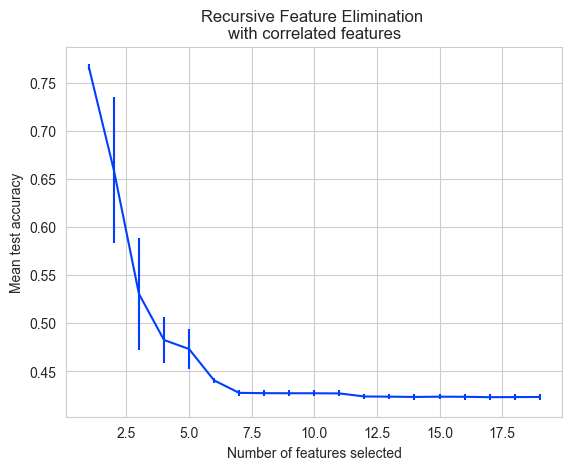

In [708]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=-cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [709]:
selected_features = X_train_zip_tf.columns[rfecv.support_]
print("Selected features:", selected_features.tolist())
print(f"Number of selected features: {len(selected_features)}")

Selected features: ['pickup_period_of_day_Afternoon', 'pickup_period_of_day_Morning', 'pickup_period_of_day_Night', 'road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine', 'pickup_month', 'pickup_day', 'pickup_hour', 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'is_weekend', 'is_rush_hour']
Number of selected features: 17


In [710]:
feature_ranks = pd.Series(rfecv.ranking_, index=X_train_zip_tf.columns).sort_values()
print(feature_ranks)

pickup_period_of_day_Afternoon    1
pickup_period_of_day_Morning      1
road_distance_manhattan           1
pickup_period_of_day_Night        1
road_distance_vincenty            1
road_distance_haversine           1
pickup_day                        1
pickup_month                      1
passenger_count                   1
pickup_longitude                  1
pickup_hour                       1
vendor_id                         1
pickup_latitude                   1
dropoff_longitude                 1
is_weekend                        1
dropoff_latitude                  1
is_rush_hour                      1
pickup_period_of_day_Evening      2
store_and_fwd_flag_Y              3
dtype: int64


In [711]:
lightgbm_regressor.fit(X=X_train_zip_tf[selected_features], y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.710805
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (14.24 MB) transferred to GPU in 0.015528 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [712]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf[selected_features])
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [713]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 316.02
MSE: 10165569.00
RMSE: 3188.35
R2: 0.03
RMSLE: 0.42


In [714]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   600.440985
702763      524   629.898924
1094869     256   347.036450
348453      528   711.213407
445599     1164  1022.684044
...         ...          ...
762043     1036   830.652491
731741     1097   995.987647
285926      374   322.693782
887221      545   526.683415
938122      479   665.340806

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [715]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [716]:
rfecv = RFECV(
    estimator=lightgbm_regressor,
    step=1,
    scoring='neg_root_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1,
    verbose=2
)

In [717]:
rfecv.fit(X=X_train_sub_tf, y=y_train_sub_log)

Fitting estimator with 19 features.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805608
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 19
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (22.26 MB) transferred to GPU in 0.028061 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained 

RFECV(estimator=LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1,
                              objective='regression', random_state=42,
                              verbose=2),
      n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2)

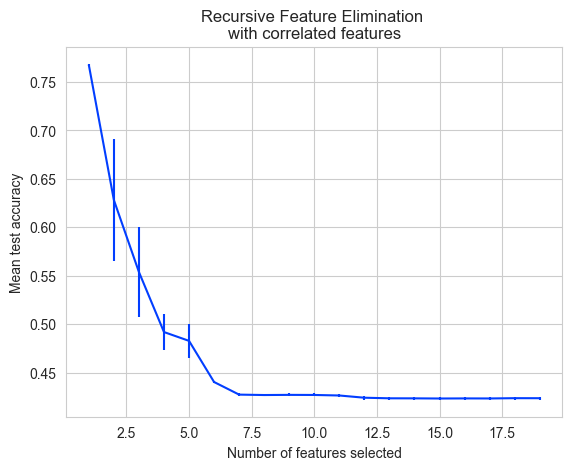

In [718]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=-cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [719]:
feature_ranks = pd.Series(rfecv.ranking_, index=X_train_sub_tf.columns).sort_values()
print(feature_ranks)

pickup_period_of_day_Morning      1
road_distance_haversine           1
road_distance_vincenty            1
road_distance_manhattan           1
vendor_id                         1
pickup_hour                       1
pickup_day                        1
pickup_month                      1
passenger_count                   1
pickup_longitude                  1
pickup_latitude                   1
dropoff_longitude                 1
is_weekend                        1
is_rush_hour                      1
dropoff_latitude                  1
pickup_period_of_day_Afternoon    2
pickup_period_of_day_Night        3
pickup_period_of_day_Evening      4
store_and_fwd_flag_Y              5
dtype: int64


In [720]:
selected_features = X_train_sub_tf.columns[rfecv.support_]
print("Selected features:", selected_features.tolist())
print(f"Number of selected features: {len(selected_features)}")

Selected features: ['pickup_period_of_day_Morning', 'road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine', 'pickup_month', 'pickup_day', 'pickup_hour', 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'is_weekend', 'is_rush_hour']
Number of selected features: 15


In [721]:
lightgbm_regressor.fit(X=X_train_sub_tf[selected_features], y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.728760
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 15
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (16.69 MB) transferred to GPU in 0.022552 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [722]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf[selected_features])
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [723]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay_isRushHour)_fs(RFECV)_default_lightgbm.csv', 
                     index=False)

Kaggle Score: `0.42972 | 0.43208`

### eXtreme Gradient Boosting (XGBoost)

In [724]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42,
                                 device='gpu',
                                 verbosity=2)

#### Local Scoring Training

In [725]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

rfecv = RFECV(
    estimator=xgboost_regressor,
    step=1,
    scoring='neg_root_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1,
    verbose=2
)

In [726]:
rfecv.fit(X=X_train_zip_tf, y=y_train_zip_log)

Fitting estimator with 19 features.
[11:37:53] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 19, 17737108).
[11:37:53] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
Fitting estimator with 18 features.
[11:37:54] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 18, 16803576).
[11:37:54] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
Fitting estimator with 17 features.
[11:37:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 17, 15870044).
[11:37:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
[11:37:56] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Fin

RFECV(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device='gpu',
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, feature_weights=None,
                             gamma=None, grow_policy=None, importance_type=None,
                             interaction_constraints=None, learning_rate=None,
                             max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, multi_strategy=None,
                             n_estimators=None, n_jobs=-1,
                             num_parallel_tree=None, ...),
      n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2)

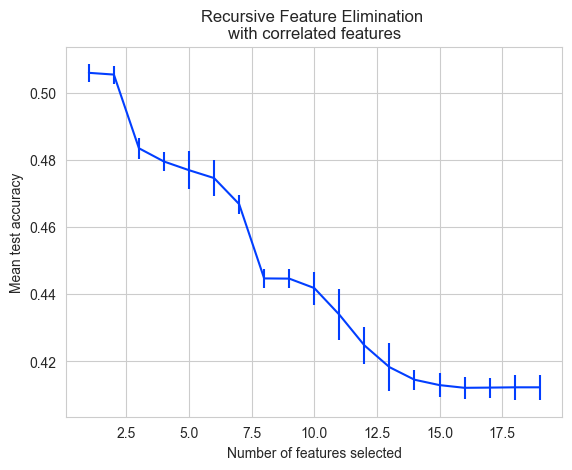

In [727]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=-cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [728]:
feature_ranks = pd.Series(rfecv.ranking_, index=X_train_zip_tf.columns).sort_values()
print(feature_ranks)

pickup_period_of_day_Afternoon    1
pickup_period_of_day_Morning      1
road_distance_manhattan           1
pickup_period_of_day_Night        1
road_distance_vincenty            1
road_distance_haversine           1
pickup_day                        1
pickup_month                      1
passenger_count                   1
pickup_longitude                  1
pickup_hour                       1
vendor_id                         1
pickup_latitude                   1
dropoff_longitude                 1
is_rush_hour                      1
dropoff_latitude                  1
pickup_period_of_day_Evening      2
store_and_fwd_flag_Y              3
is_weekend                        4
dtype: int64


In [729]:
selected_features = X_train_zip_tf.columns[rfecv.support_]
print("Selected features:", selected_features.tolist())
print(f"Number of selected features: {len(selected_features)}")

Selected features: ['pickup_period_of_day_Afternoon', 'pickup_period_of_day_Morning', 'pickup_period_of_day_Night', 'road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine', 'pickup_month', 'pickup_day', 'pickup_hour', 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'is_rush_hour']
Number of selected features: 16


In [730]:
xgboost_regressor.fit(X=X_train_zip_tf[selected_features], y=y_train_zip_log)

[11:37:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 16, 14936512).
[11:37:59] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [731]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf[selected_features])
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [732]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [733]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 304.36
MSE: 10151428.00
RMSE: 3186.13
R2: 0.03
RMSLE: 0.41


In [734]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   531.146301
702763      524   613.811768
1094869     256   361.018036
348453      528   645.798584
445599     1164  1061.607544
...         ...          ...
762043     1036   867.766235
731741     1097  1244.561523
285926      374   344.000854
887221      545   562.382935
938122      479   584.945129

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [735]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [736]:
rfecv = RFECV(
    estimator=xgboost_regressor,
    step=1,
    scoring='neg_root_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1,
    verbose=2
)

In [737]:
rfecv.fit(X=X_train_sub_tf, y=y_train_sub_log)

Fitting estimator with 19 features.
[11:39:47] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 19, 27714236).
[11:39:47] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
Fitting estimator with 18 features.
[11:39:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 18, 26255592).
[11:39:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
[11:39:50] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 17, 24796948).
[11:39:50] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
[11:39:52] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `Iterative

RFECV(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device='gpu',
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, feature_weights=None,
                             gamma=None, grow_policy=None, importance_type=None,
                             interaction_constraints=None, learning_rate=None,
                             max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, multi_strategy=None,
                             n_estimators=None, n_jobs=-1,
                             num_parallel_tree=None, ...),
      n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2)

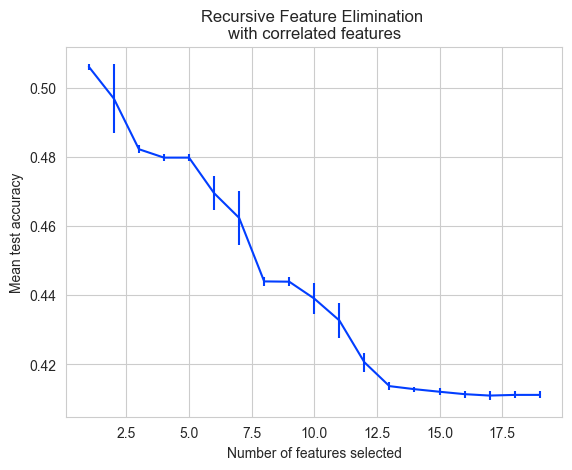

In [738]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=-cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [739]:
feature_ranks = pd.Series(rfecv.ranking_, index=X_train_sub_tf.columns).sort_values()
print(feature_ranks)

pickup_period_of_day_Afternoon    1
pickup_period_of_day_Evening      1
pickup_period_of_day_Morning      1
pickup_period_of_day_Night        1
road_distance_vincenty            1
road_distance_manhattan           1
road_distance_haversine           1
pickup_month                      1
passenger_count                   1
pickup_day                        1
pickup_hour                       1
vendor_id                         1
pickup_latitude                   1
pickup_longitude                  1
dropoff_longitude                 1
dropoff_latitude                  1
is_rush_hour                      1
store_and_fwd_flag_Y              2
is_weekend                        3
dtype: int64


In [740]:
selected_features = X_train_sub_tf.columns[rfecv.support_]
print("Selected features:", selected_features.tolist())
print(f"Number of selected features: {len(selected_features)}")

Selected features: ['pickup_period_of_day_Afternoon', 'pickup_period_of_day_Evening', 'pickup_period_of_day_Morning', 'pickup_period_of_day_Night', 'road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine', 'pickup_month', 'pickup_day', 'pickup_hour', 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'is_rush_hour']
Number of selected features: 17


In [741]:
xgboost_regressor.fit(X=X_train_sub_tf[selected_features], y=y_train_sub_log)

[11:39:54] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 17, 24796948).
[11:39:54] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [742]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf[selected_features])
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [743]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay_isRushHour)_FS(RFECV)_default_xgboost.csv', index=False)

Kaggle Score: `0.42092 | 0.42261`

### Linear Regression

In [744]:
linear_regressor = LinearRegression(n_jobs=-1)

In [745]:
rfecv = RFECV(
    estimator=linear_regressor,
    step=1,
    scoring='neg_root_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1,
    verbose=2
)

In [746]:
rfecv.fit(X=X_train_zip_tf, y=y_train_zip_log)

RFECV(estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
      scoring='neg_root_mean_squared_error', verbose=2)

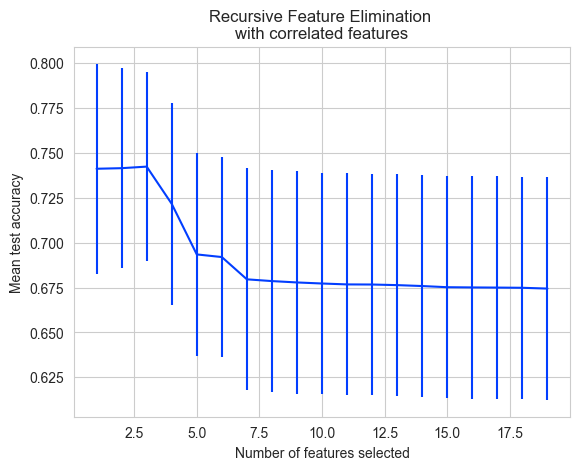

In [747]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=-cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [748]:
feature_ranks = pd.Series(rfecv.ranking_, index=X_train_zip_tf.columns).sort_values()
print(feature_ranks)

store_and_fwd_flag_Y              1
pickup_period_of_day_Afternoon    1
pickup_period_of_day_Evening      1
pickup_period_of_day_Morning      1
pickup_period_of_day_Night        1
road_distance_manhattan           1
road_distance_vincenty            1
road_distance_haversine           1
pickup_month                      1
pickup_day                        1
pickup_hour                       1
vendor_id                         1
passenger_count                   1
pickup_longitude                  1
pickup_latitude                   1
dropoff_longitude                 1
dropoff_latitude                  1
is_weekend                        1
is_rush_hour                      1
dtype: int64


In [749]:
selected_features = X_train_zip_tf.columns[rfecv.support_]
print("Selected features:", selected_features.tolist())
print(f"Number of selected features: {len(selected_features)}")

Selected features: ['store_and_fwd_flag_Y', 'pickup_period_of_day_Afternoon', 'pickup_period_of_day_Evening', 'pickup_period_of_day_Morning', 'pickup_period_of_day_Night', 'road_distance_manhattan', 'road_distance_vincenty', 'road_distance_haversine', 'pickup_month', 'pickup_day', 'pickup_hour', 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'is_weekend', 'is_rush_hour']
Number of selected features: 19


In [750]:
linear_regressor.fit(X=X_train_zip_tf[selected_features], y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [751]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf[selected_features])
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [752]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [753]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 4645915547809241088.00
MSE: 5037462663107759310212146880821147081900032.00
RMSE: 2244429251080942256128.00
R2: -479794760743143093653255546258587648.00
RMSLE: 0.63


In [754]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred      y_pred
1298895     363  586.034741
702763      524  520.448713
1094869     256  466.432353
348453      528  603.346731
445599     1164  707.210910
...         ...         ...
762043     1036  608.824329
731741     1097  574.987013
285926      374  426.417946
887221      545  536.993729
938122      479  556.245101

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [755]:
linear_regressor = LinearRegression(n_jobs=-1)

In [756]:
rfecv = RFECV(
    estimator=linear_regressor,
    step=1,
    scoring='neg_root_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1,
    verbose=2
)

In [757]:
rfecv.fit(X=X_train_sub_tf, y=y_train_sub_log)

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


RFECV(estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
      scoring='neg_root_mean_squared_error', verbose=2)

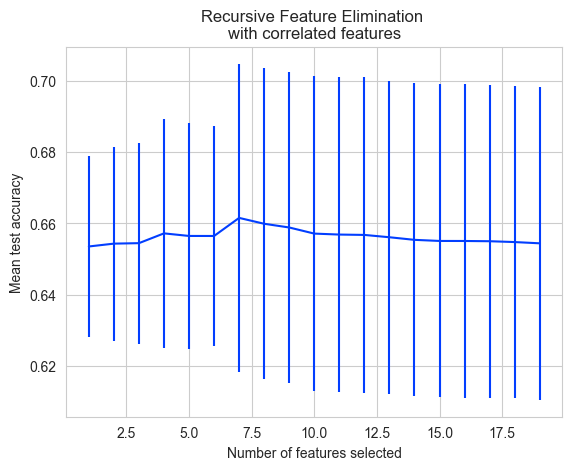

In [758]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=-cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [759]:
feature_ranks = pd.Series(rfecv.ranking_, index=X_train_sub_tf.columns).sort_values()
print(feature_ranks)

road_distance_haversine            1
road_distance_vincenty             2
dropoff_latitude                   3
pickup_longitude                   4
dropoff_longitude                  5
pickup_latitude                    6
pickup_period_of_day_Afternoon     7
is_weekend                         8
pickup_period_of_day_Night         9
road_distance_manhattan           10
pickup_period_of_day_Morning      11
vendor_id                         12
pickup_period_of_day_Evening      13
pickup_month                      14
pickup_day                        15
passenger_count                   16
is_rush_hour                      17
store_and_fwd_flag_Y              18
pickup_hour                       19
dtype: int64


In [760]:
selected_features = X_train_sub_tf.columns[rfecv.support_]
print("Selected features:", selected_features.tolist())
print(f"Number of selected features: {len(selected_features)}")

Selected features: ['road_distance_haversine']
Number of selected features: 1


In [761]:
linear_regressor.fit(X=X_train_sub_tf[selected_features], y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [762]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf[selected_features])
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [763]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [764]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay_isRushHour)_FS(RFECV)_default_linearRegr.csv', index=False)

Kaggle Score: `0.66023 | 0.64466`

## Model Training - Feature Engineering + Hyperparameter Tuning

In [765]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('distance to km', road_distance_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('derive_day_period', day_period_transformer),
    ('derive_rush_hour', rush_hour_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_features', feature_encoder_transformer)
]

In [766]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [767]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/33 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/233383 [00:00<?, ?it/s]

In [768]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [769]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Rush Hour:   0%|          | 0/625134 [00:00<?, ?it/s]

### Light Gradient Boost Model (LightGBM)

#### Local Scoring Training

In [ ]:
def objective_lightgbm(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    lightgbm_regressor = LGBMRegressor(**param, n_jobs=-1, random_state=42, device='gpu')

    lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

    y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
    y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                            index=X_test_zip_tf.index,
                            name='trip_duration'
                            )
    
    return root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf)

In [771]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_lightgbm, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-17 11:44:47,858] A new study created in memory with name: no-name-fd9b7c3b-9a80-471f-a778-64b5e9b52bfb
[I 2025-07-17 11:44:56,579] Trial 0 finished with value: 0.4553804197760703 and parameters: {'learning_rate': 0.013576777094819715, 'lambda_l1': 1.1693846610097176, 'lambda_l2': 2.7679128295016267e-07, 'n_estimators': 531, 'num_leaves': 62, 'max_depth': 3, 'min_data_in_leaf': 43, 'feature_fraction': 0.5221886771640806, 'bagging_fraction': 0.5297483763551357, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 0 with value: 0.4553804197760703.
[I 2025-07-17 11:45:32,235] Trial 1 finished with value: 0.4576939745059459 and parameters: {'learning_rate': 0.0029120701221727707, 'lambda_l1': 1.542920252021147e-05, 'lambda_l2': 9.488741247477342e-06, 'n_estimators': 687, 'num_leaves': 163, 'max_depth': 7, 'min_data_in_leaf': 22, 'feature_fraction': 0.690440536146957, 'bagging_fraction': 0.6323565002619739, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 0 with va

Number of finished trials: 50
Best trial:
  Value: 0.39240981102789213
  Params: 
    learning_rate: 0.07236222588300983
    lambda_l1: 0.2099308131390967
    lambda_l2: 3.2836813890110245e-08
    n_estimators: 723
    num_leaves: 254
    max_depth: 9
    min_data_in_leaf: 15
    feature_fraction: 0.8717638933914758
    bagging_fraction: 0.9712323089436476
    bagging_freq: 4
    min_child_samples: 89


In [772]:
lightgbm_regressor = LGBMRegressor(
    **study.best_trial.params,
    objective='regression', 
    metric = 'rmse',
    n_jobs=-1,
    random_state=42,
    device='gpu',
    verbose=2
)

In [773]:
lightgbm_regressor.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.07236222588300983,
 'max_depth': 9,
 'min_child_samples': 89,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 723,
 'n_jobs': -1,
 'num_leaves': 254,
 'objective': 'regression',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'lambda_l1': 0.2099308131390967,
 'lambda_l2': 3.2836813890110245e-08,
 'min_data_in_leaf': 15,
 'feature_fraction': 0.8717638933914758,
 'bagging_fraction': 0.9712323089436476,
 'bagging_freq': 4,
 'metric': 'rmse',
 'device': 'gpu',
 'verbose': 2}

In [774]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8717638933914758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8717638933914758
[LightGBM] [Warning] lambda_l1 is set=0.2099308131390967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2099308131390967
[LightGBM] [Warning] lambda_l2 is set=3.2836813890110245e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2836813890110245e-08
[LightGBM] [Warning] bagging_fraction is set=0.9712323089436476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712323089436476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8717638933914758, colsamp

LGBMRegressor(bagging_fraction=0.9712323089436476, bagging_freq=4, device='gpu',
              feature_fraction=0.8717638933914758, lambda_l1=0.2099308131390967,
              lambda_l2=3.2836813890110245e-08,
              learning_rate=0.07236222588300983, max_depth=9, metric='rmse',
              min_child_samples=89, min_data_in_leaf=15, n_estimators=723,
              n_jobs=-1, num_leaves=254, objective='regression',
              random_state=42, verbose=2)

In [775]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8717638933914758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8717638933914758
[LightGBM] [Warning] lambda_l1 is set=0.2099308131390967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2099308131390967
[LightGBM] [Warning] lambda_l2 is set=3.2836813890110245e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2836813890110245e-08
[LightGBM] [Warning] bagging_fraction is set=0.9712323089436476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712323089436476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [776]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 291.82
MSE: 10141879.01
RMSE: 3184.63
R2: 0.03
RMSLE: 0.39


In [777]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   458.695425
702763      524   545.646329
1094869     256   320.484771
348453      528   579.634949
445599     1164   948.833432
...         ...          ...
762043     1036   901.626083
731741     1097  1292.143327
285926      374   425.076696
887221      545   545.312140
938122      479   583.750355

[233383 rows x 2 columns]

#### Kaggle Submission Training

Since there are no true labels given, the params found in the previous subsection will be used

In [778]:
lightgbm_regressor = LGBMRegressor(
    **study.best_trial.params,
    objective='regression', 
    metric = 'rmse',
    n_jobs=-1,
    random_state=42,
    device='gpu',
    verbose=2
)

In [779]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8717638933914758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8717638933914758
[LightGBM] [Warning] lambda_l1 is set=0.2099308131390967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2099308131390967
[LightGBM] [Warning] lambda_l2 is set=3.2836813890110245e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2836813890110245e-08
[LightGBM] [Warning] bagging_fraction is set=0.9712323089436476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712323089436476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8717638933914758, colsamp

LGBMRegressor(bagging_fraction=0.9712323089436476, bagging_freq=4, device='gpu',
              feature_fraction=0.8717638933914758, lambda_l1=0.2099308131390967,
              lambda_l2=3.2836813890110245e-08,
              learning_rate=0.07236222588300983, max_depth=9, metric='rmse',
              min_child_samples=89, min_data_in_leaf=15, n_estimators=723,
              n_jobs=-1, num_leaves=254, objective='regression',
              random_state=42, verbose=2)

In [780]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8717638933914758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8717638933914758
[LightGBM] [Warning] lambda_l1 is set=0.2099308131390967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2099308131390967
[LightGBM] [Warning] lambda_l2 is set=3.2836813890110245e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2836813890110245e-08
[LightGBM] [Warning] bagging_fraction is set=0.9712323089436476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712323089436476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [781]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_HP(Optuna)_lightgbm.csv', 
                     index=False)

Kaggle Score: `0.40015 | 0.40234`

### eXtreme Gradient Boosting (XGBoost)

#### Local Scoring Training

In [805]:
def objective_xgboost(trial):
    param = {
        'verbosity': 0,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        # 'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 1.0),
        # 'colsample_bynode': trial.suggest_float('colsample_bynode', 0.01, 1.0),
    }

    xgboost_regressor = XGBRegressor(**param, n_jobs=-1, random_state=42, device='cuda', tree_method='gpu_hist')

    xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

    y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
    y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                            index=X_test_zip_tf.index,
                            name='trip_duration'
                            )
    
    return root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf)

In [806]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgboost, n_trials=25)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-17 14:40:20,714] A new study created in memory with name: no-name-32dc7ac9-790c-4bfe-b549-88983d333059
[I 2025-07-17 14:41:13,712] Trial 0 finished with value: 0.39730945229530334 and parameters: {'learning_rate': 0.025903031768285883, 'gamma': 5.092137575784836e-08, 'lambda': 0.11886878184416695, 'alpha': 0.023041746440779214, 'n_estimators': 614, 'max_depth': 16, 'min_child_weight': 16, 'max_delta_step': 2, 'subsample': 0.26590371450362293, 'colsample_bytree': 0.664014208248152}. Best is trial 0 with value: 0.39730945229530334.
[I 2025-07-17 14:41:36,209] Trial 1 finished with value: 0.5506236553192139 and parameters: {'learning_rate': 0.0014954942032524845, 'gamma': 0.00027876432769350837, 'lambda': 0.00011479341008772721, 'alpha': 0.0037123445193525738, 'n_estimators': 486, 'max_depth': 11, 'min_child_weight': 5, 'max_delta_step': 7, 'subsample': 0.1905648661685302, 'colsample_bytree': 0.6526009421346907}. Best is trial 0 with value: 0.39730945229530334.
[I 2025-07-17 14

Number of finished trials: 25
Best trial:
  Value: 0.3945373594760895
  Params: 
    learning_rate: 0.028082152637624293
    gamma: 2.0008890557000935e-07
    lambda: 0.0002112705986364397
    alpha: 0.3850763990340016
    n_estimators: 918
    max_depth: 20
    min_child_weight: 39
    max_delta_step: 5
    subsample: 0.9354943050009652
    colsample_bytree: 0.5954416910841029


In [807]:
xgboost_regressor = XGBRegressor(
    **study.best_trial.params,
    n_jobs=-1,
    random_state=42,
    device='gpu',
    verbose=2
)

In [808]:
xgboost_regressor.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.5954416910841029,
 'device': 'gpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': 2.0008890557000935e-07,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.028082152637624293,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 5,
 'max_depth': 20,
 'max_leaves': None,
 'min_child_weight': 39,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 918,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9354943050009652,
 'tree_method': None,
 'validate_parameters': None,
 've

In [809]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

d:\Programming\Projects\Sigmoid\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(alpha=0.3850763990340016, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5954416910841029, device='gpu',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=2.0008890557000935e-07, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=0.0002112705986364397, learning_rate=0.028082152637624293,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=5, max_depth=20, max_leaves=None,
             min_child_weight=39, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=918, ...)

In [813]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [814]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 290.17
MSE: 10139507.00
RMSE: 3184.26
R2: 0.03
RMSLE: 0.39


In [815]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

y_pred       y_pred
1298895     363   421.385742
702763      524   564.488708
1094869     256   330.057892
348453      528   586.193420
445599     1164   933.690735
...         ...          ...
762043     1036   851.759399
731741     1097  1363.197754
285926      374   489.651215
887221      545   592.770142
938122      479   564.188416

[233383 rows x 2 columns]

#### Kaggle Submission Training

In [816]:
study.best_trial.params

{'learning_rate': 0.028082152637624293,
 'gamma': 2.0008890557000935e-07,
 'lambda': 0.0002112705986364397,
 'alpha': 0.3850763990340016,
 'n_estimators': 918,
 'max_depth': 20,
 'min_child_weight': 39,
 'max_delta_step': 5,
 'subsample': 0.9354943050009652,
 'colsample_bytree': 0.5954416910841029}

In [817]:
xgboost_regressor = XGBRegressor(
    **study.best_trial.params,
    n_jobs=-1,
    random_state=42,
    device='gpu',
    verbose=2
)

In [818]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

d:\Programming\Projects\Sigmoid\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:27:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(alpha=0.3850763990340016, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5954416910841029, device='gpu',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=2.0008890557000935e-07, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=0.0002112705986364397, learning_rate=0.028082152637624293,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=5, max_depth=20, max_leaves=None,
             min_child_weight=39, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=918, ...)

In [819]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [820]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance(ManhVincHaver)_isWeekend_periodDay)_HP(Optuna)_xgboost.csv', 
                     index=False)

Kaggle Score: `0.40506 | 0.40700`